# Machine Learning and Statistics Project 2020
by Angela Carpenter



## Project Instructions

The aim of this project is to create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. A web service must also be developed that will respond with predicted power values based on speed values sent as HTTP requests. 

In this notebook I trained and developed machine learning models using the data set. The models used are explained and the accuracy of the models are analysed. The models used are polynomial regression models and artificial neural networks. 
- The first section of the notebook contains some exploratory data analysis on the data set.
- The next part provides some background on power output from wind turbines for some context and to understand the data involved.
- The machine learning models used are explained in the next section before applying the models to the data and the accuracy of the models analysed.
- The machine learning models used are then compared to each other.
- References are listed at the end of the notebook.


### Read in the dataset

### Import Python libraries


In [2]:
# first importing the following libraries
import numpy as np
# pandas dataframes
import pandas as pd  
# plotting library
import matplotlib.pyplot as plt 
# another plotting library
import seaborn as sns
# splitting dataset into training and testing sets
import sklearn
print(sklearn.__version__)
from sklearn.model_selection import train_test_split
# for polynomial regression 
from sklearn.preprocessing import PolynomialFeatures
# for linear regression 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
# for evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
# neural networks
import tensorflow.keras as kr
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# save a model in scikit-learn by using Python’s built-in persistence model pickle:
import pickle
# In the specific case of scikit-learn, it may be better to use joblib’s replacement of pickle
import joblib
from joblib import dump, load
print (joblib.__version__)

0.23.2
0.16.0


### Import the dataset
The dataset is available from [Github](https://github.com/ianmcloughlin/2020A-machstat-project).[1]

In [3]:
# save link to data and reference the link 
csv_url = 'https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv'
# read the csv data into a pandas dataframe
df = pd.read_csv(csv_url)
df
# write the dataframe to csv
df.to_csv('df.csv')
# make a copy of the dataframe
dfx = df.copy()

## Exploratory Data Analysis on the dataset
The power variable represents wind turbine power output and the speed values are wind speed values. This is all that has been provided. There are no null values in the dataset but there are 49 observations with zero values. 
While there is only one zero value for the `speed` variable, there are 49 zero values for the `power` variable.
Some research below suggests that the wind speed values are measured in metres per second and that the power values are measured in kilowatts, although it could be megawatts based on the values in the dataset. However this will not affect the analysis.

Exploratory data analysis generally involves both non-graphical methods which include calculation of summary statistics and graphical methods which summarises the data in a picture or a plot. 
Visualisations can highlight any obvious relationships between the different variables in the dataset and to identify any groups of observations that are clearly separate to other groups of observations.

In [4]:
df.head()


,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [5]:
df.tail()

,speed,power
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0
499,25.000,0.0


In [6]:
# can have a look at the dataset
df.sort_values(by='power', ascending=False).head()
df.sort_values(by='power').head()
df.sort_values(by='speed').head()
# check for null values
df.isnull().values.any()
df.isnull().sum()
# check for zero values
df.isin([0]).sum()


speed     1
power    49
dtype: int64

### The distribution of the data
A histogram can be used to show the distribution of a single quantitative variable such as speed or power values, including the centre and spread of the distribution and if there is any skew in the data. Wind speed appears to be  uniformly distributed with values spread out from zero up to a maximum value of 25. Power output values on the other hand looks to be bimodal with two defined peaks, one around zero power values and the second around the 100 kilowatt mark. The first peak is betweeen power values of 0 and 5. This is not surprising given the large number of zero power values in this dataset. Almost 10% of the power values supplied are zero.  There is another smaller peak around values of 95-100. Most of the remaining power values fall between 18 and 85.

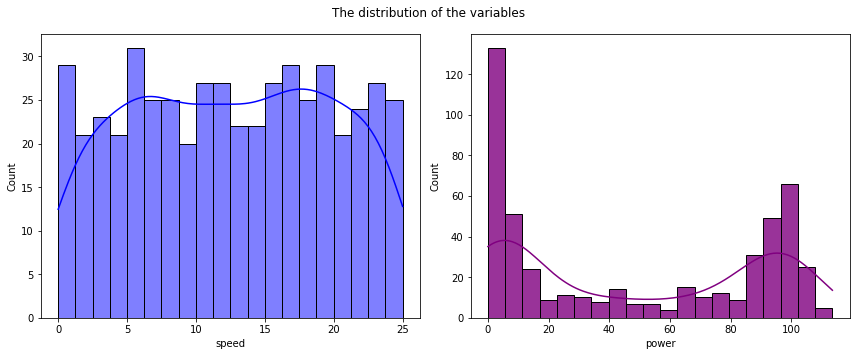

In [7]:
    %matplotlib inline

    # plot the histograms of Speed values
    f, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(data=df, x="speed", ax=axs[0], bins=20, kde=True,color="blue")
    sns.histplot(data=df, x="power", alpha=.8, legend=False, ax=axs[1], bins=20, kde=True, color="purple")

    #plt.title("Speed vs Power");
    plt.suptitle("The distribution of the variables")
    f.tight_layout()

### The relationship between the variables wind speed and power output.

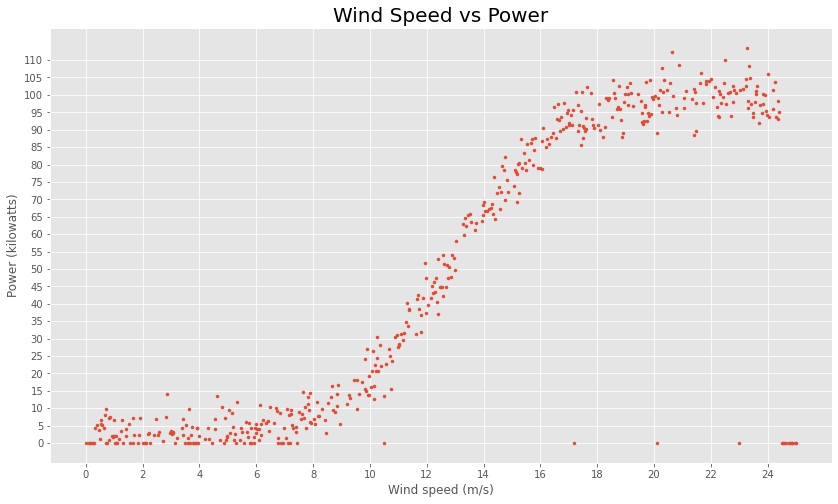

In [8]:
# create the plot
plt.style.use('ggplot')
# Plot size.
plt.rcParams['figure.figsize'] = (14, 8)


plt.scatter(df['speed'],df['power'], marker=".")
# https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
plt.yticks(np.arange(min(df['power']), max(df['power'])+1, 5.0))
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 2.0))
#sns.scatterplot(x=df['speed'],y=df['power'], marker="x")
plt.grid(True)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kilowatts)")
# add title
plt.title("Wind Speed vs Power", fontsize=20);
plt.savefig("Wind Speed Power scatterplot.png")
plt.show()

Scatter plots are useful to identify trends and patterns in a dataset which might indicate a relationship between two numerical variables such as we have in this dataset. The ordered pairs of numbers consisting of the independent variable wind 'speed' and the dependent variable 'power' output are plotted below resulting in a joint distribution of the two variables. Each point represents an actual observation is the dataset with a speed and a corresponding power value. 
The scatter plot above shows an increasing linear trend in the middle range of the wind speed values. This would indicate that for increasing wind speeds in this range, power output values do increase, but only after a minimum wind speed has been reached. Power outputs then increase in line with increases in wind speed until it reaches a peak and levels off. The plot suggests that very low winds may not be enough to get the turbine going and that the turbines have a maximum power level. Once the turbine is in motion perhaps little is required to keep it going. Some of the power generated might be consumed by the turbine itself at low levels to get it started.

#### Correlation and Covariance of Speed and Power values
 
For two quantitative variables such as the wind speed and power values, the covariance and correlation can also be used to determine whether a linear relationship between variables does exist and to show if one variable tends to occur with large or small values of another variable. The correlation statistics puts a numerical value on the strength and direction of the relationship.  The correlation coefficient here of 0.85 shows there is a very strong positive relationship between the wind speed and turbine power output.  The scatter plot shows a curved  relationship between the variables. There appears to be a curvilinear pattern in the data.

In [9]:
df.corr()

,speed,power
speed,1.000000,0.853778
power,0.853778,1.000000


### Some summary statistics of the dataset:
When looking at quantitative variables such as wind speed and power values, the characteristics of interest are the centre, spread, modality, the shape of the distribution and the outliers.  The central tendency or location of the data distribution is determined by the typical or middle values. While the mean value is the average value in the dataset it may not be typical of the values in the dataset if there are very small or very large values in the dataset. The median is another measure of central tendancy - it is the middle value after all the values are put in an ordered list.
The mean and median are similar for symmetric distributions whereas for unimodal skewed distributions the mean will be more in the direction of the long tail of the distribution. 
The median can be considered a more typical value in the dataset or closer to some of the typical values and is also considered robust which means that removing some of the data will not tend to change the value of the median. A few extreme values will not affect the median as they would affect the mean. 
In this dataset the mean and median wind speed values are similar at approx 12.5 to 12.6 metres per second.
The median power value is just over 41 unit compared to the mean power value of 48 (kws).
As we saw above, there are many zero values for power in the dataset. At least 10% of the power values in the dataset are zero.

The variance and standard deviation statistics can be used to show the spread of the distribution of the speed and power data values and how far away from the centre the data points are located. The variance is the average of the squared deviations of each observation from the centre or mean of the data while the standard deviation is the square root of the variance and is in the same units as the data and therefore can be more easily interpreted. 
The range of values in the data is shown by the minimum and maximum values and is not considered a robust measure of spread but it is useful for showing possible errors or outliers.

The percentiles or quartiles of the speed and power values can be used to see the spread of the data values. The Interquartile range (IQR) is calculated by taking the 75% percentile or 3rd quartile minus the 25% percentile or first quartile and captures half of the values, the middle values of the data. Data that is more spread out will have a higher IQR. The IQR is considered a more robust measure of spread than the variance and standard deviation and will be more clearly shown in the boxplots further down. The IQR does not consider the data below the 25% percentile or above the 75% percentile which may contain outliers. The statistics here show that the *power* variable in this dataset is much more spread out or variable than the *speed* variable. 

In [10]:
# using pandas summary statistics of the numerical values
df.describe() 

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


In [11]:
print("The mean speed value is %.3f" %df['speed'].mean(),"while the median speed value  is %.3f" %df['speed'].quantile(q=0.5))
print("The mean power value is %.3f" %df['power'].mean(),"while the median power value  is %.3f" %df['power'].quantile(q=0.5))
#print(f"The variance and standard deviations of speed values  are {df['speed'].var():.3f} and {df['speed'].std():.3f}")
#print(f"The variance and standard deviations of power values are {df['power'].var():.3f} and {df['power'].std():.3f}")
print(f"The standard deviations of speed values  is {df['speed'].std():.3f}")
print(f"The standard deviations of power values is {df['power'].std():.3f}")
print(f"The minimum speed value is {df['speed'].min()} while the maximum speed value is { df['speed'].max()} giving range of {df['speed'].max() - df['speed'].min()}")
print(f"The minimum Power value is {df['power'].min()} while the maximum power value is { df['power'].max()} giving range of {df['power'].max() - df['power'].min()}")
print(f"The median speed value is {df['speed'].quantile(q=0.5)} with the IQR ranging from {df['speed'].quantile(q=0.25):.2f} to  {df['speed'].quantile(q=0.75):.2f}")
print(f"The median power value is {df['power'].quantile(q=0.5)} with the IQR ranging from {df['power'].quantile(q=0.25):.2f} to  {df['power'].quantile(q=0.75):.2f}")

The mean speed value is 12.590 while the median speed value  is 12.550
The mean power value is 48.015 while the median power value  is 41.645
The standard deviations of speed values  is 7.225
The standard deviations of power values is 41.615
The minimum speed value is 0.0 while the maximum speed value is 25.0 giving range of 25.0
The minimum Power value is 0.0 while the maximum power value is 113.556 giving range of 113.556
The median speed value is 12.5505 with the IQR ranging from 6.32 to  18.78
The median power value is 41.6455 with the IQR ranging from 5.29 to  93.54


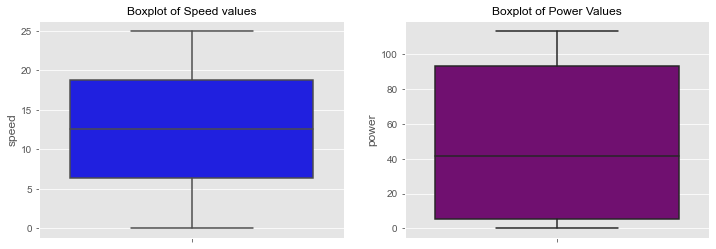

In [12]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.set(style="ticks", palette="pastel")
sns.boxplot(y=df['speed'], ax=axes[0], color="blue")
# add a title
axes[0].set_title("Boxplot of Speed values")
sns.boxplot(y=df['power'], ax=axes[1], color="purple")
axes[1].set_title("Boxplot of Power Values");

The skewness of the data is a measure of assymetry which can be seen by the lopsidedness of a boxplot.
Wind speed appears to be quite symmetric. The wind speed boxplot is cut pretty much in half by the median. Power appears to be somewhat skewed to the right as the boxplot shows more of the box to the right or above the median line.
A boxplot with the median closer to the lower quartile is considered positively skewed. Positively skewed data has the mean greater than the median and it can be interpreted as having a higher frequency of high valued scores. The lower values of power are closer together than the higher power values.


### Regression plots
The Python Seaborn library has some regression plots that can be used to quickly visualise relationships and patterns that may exist in the data. They use statistical models to estimate a simple relationship between sets of observations and are mainly used to visualise patterns in a dataset during the exploratory data analysis.
The scatter plot earlier showed a relationship between wind speeds and wind turbine power that is non-linear. There does seem to be a somewhat linear relationship for wind speeds between values of about 10 up to about 18 or so.
The plot below shows that the polynomial with order 3 looks a much better fit to the line than the first or second order linear regression lines. It is important not to go down the road of overfitting the data though.

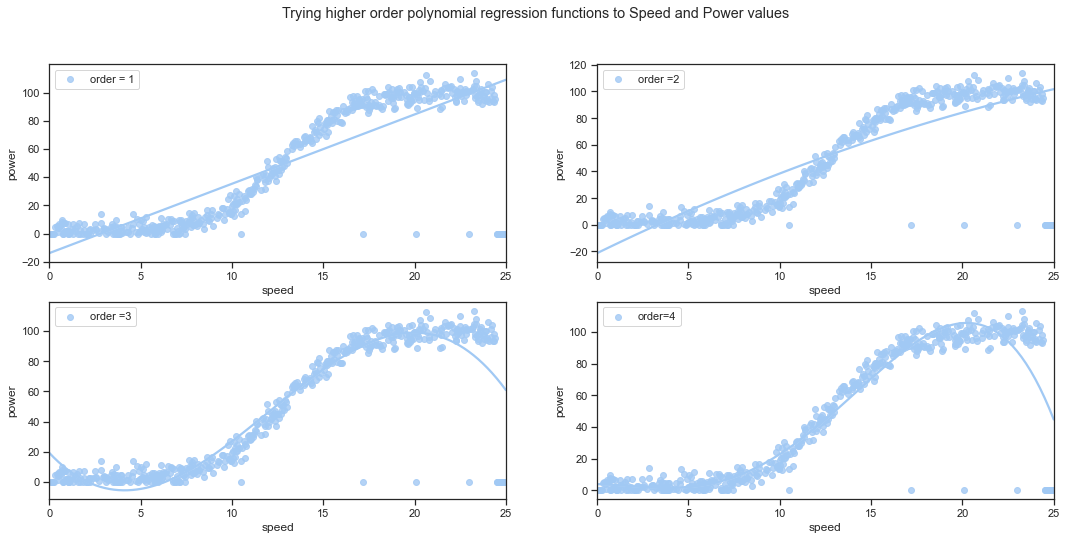

In [13]:
f, axes = plt.subplots(2, 2, figsize=(18, 8))
x = "speed"
y = "power"
sns.regplot(x="speed", y="power", data=df, ax=axes[0,0], label="order = 1", ci=False); axes[0,0].legend()
sns.regplot(x="speed", y="power", data=df, order=2, ax=axes[0,1], label="order =2", ci=False); axes[0,1].legend()
sns.regplot(x="speed", y="power", data=df, order=3, ax=axes[1,0], label="order =3", ci=False); axes[1,0].legend()
sns.regplot(x="speed", y="power", data=df, order=4, ax=axes[1,1], label = "order=4", ci=False); axes[1,1].legend()
plt.legend()
plt.suptitle("Trying higher order polynomial regression functions to Speed and Power values")
plt.show()

Residual plots can be used to check whether the simple regression model of speed ~ power  is appropriate for a dataset. The seaborn `residplot` fits and removes a simple linear regression and then plots the residual values for each observation. Ideally, these values should be randomly scattered around y = 0. If there is structure in the residuals, this suggests that simple linear regression is not appropriate for the data. The residual plot here has a shape which suggest non-linearity in the data set as expected.

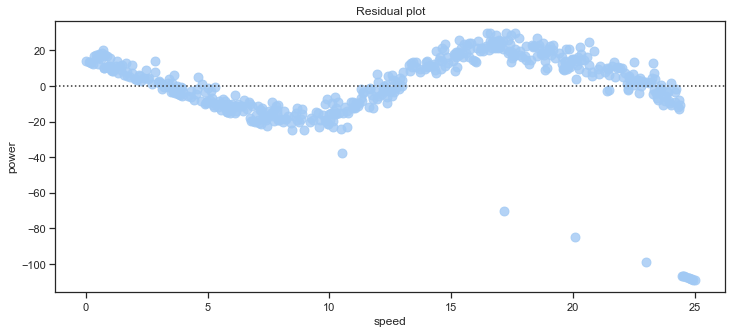

In [14]:
plt.rcParams['figure.figsize'] = (12, 5)
sns.residplot(x="speed", y="power", data=df, scatter_kws={"s": 80})
plt.title("Residual plot"); plt.show()

---
## Some background on Wind Turbines power output.

The dataset [1] consists of two columns each containing 500 floating numbers under the column names `speed` and `power`. There are no other features provided.  Before I go any further I will do a little research into the dataset which may help in understanding and  interpreting the relationship between wind speed and power output from a turbine and also in determining what conclusions can be reached based on the dataset alone. The research below also highlights the limitations and uncertainty in predicting power generated from wind turbines using local wind speed data.

Some background to the project was provided in a lecture. In the electricity supply market, the producers usually sell their electricity ahead of time and enter a contract where they agree to produce a certain number of kilowatts of electricity during a particular time frame. The price is negotiated in advance of generating electricity and pushing it onto the supply grid. Wind farms supply electricity to the supply grid and negotiate prices in advance. It is more difficult for wind farms to predict exactly how much electricity they can generate at a future date compared to other electricity producers as their generation of electricity depends on  wind power. 
For this reason predictions can be estimated based on meterological data from a weather prediction agent such as Met Eireann. The aim is to be able to predict that when wind speed is a certain amount that the power produced from the turbines is a certain amount. 

[The Irish Wind Energy Association (IWEA)](https://www.iwea.com/about-us/about-us)[2] is the representative body for the Irish wind industry, working to promote wind energy as an essential, economical and environmentally friendly part of the country’s low-carbon energy future. They note here that in 2018 wind energy provided 29 per cent of Ireland’s electricity. Each quarter, both EirGrid and ESBN publish updated wind farm statistics for Ireland at [ESBN Connected Wind Farms](https://www.esbnetworks.ie/new-connections/generator-connections/generator-connection-statistics). There is currently 4,130 MW of installed capacity in the Republic of Ireland. The amount of electricity a turbine can generate depends on the type of turbine and the wind conditions at any time. There are many different models of turbines that can generate different amounts of electricity. Ireland’s largest wind farm is the Galway Wind Park in Connemara which has 3 MW turbines. Eirgrid's [Smart grid dashboard](http://smartgriddashboard.eirgrid.com/#all/about/wind)[3] shows actual and forecast wind generation by day, week and month for all wind farms on the system while [WindEurope](https://windeurope.org/data-and-analysis/) has some facts and issues about wind energy in Europe, in particular the section on [Wind Energy Basics](https://windeurope.org/about-wind/wind-basics/). Wind is caused by three things, the heating of the atmosphere by the sun, the rotation of the Earth and the Earth's surface irregularities. *air under high pressure moves toward areas of low pressure – and the greater the difference in pressure, the faster the air flows and the stronger the wind!* [4] Energy is the ability to  do work and can be categorised into  either kinetic energy (the energy of moving objects) or potential energy (energy that is stored). Wind turbines take the kinetic energy that’s in the wind and convert that kinetic energy into mechanical power which is mostly used in the form of electricity. Wind energy captures the energy of the wind and converts it to electricity and is an alternative to burning fossil fuels. It comes from a natural and renewable resourse and it is clean as it produces no greenhouse gas, emits no air pollutants and uses very little water. 
A wind turbine is a device that converts kinetic energy from the wind into electricity. Their output ranges from as small as 100 kilowatts to as big as 12 megawatts. This suggests that the power values in the dataset for this project is not in kilowatts but possibly megawatts or may represent a wind farm rather than a single turbine. However this is of no consequence to this project.

According to this website [4], there are three main variables determining how much electricity a turbine can produce,  wind speed, blade radius and air density. Stronger winds allow more electricity to be produced with higher turbines being more receptive to strong winds. We only have the values for wind speed in the dataset here so will have to assume that the other variables are constant.

*Wind turbines generate electricity at wind speeds of 4 – 25 metres per second.* [4]
The article also outlines what happens when the wind doesn't blow. A wind farms location is usually chosen purposely and therefore when a wind turbine is not turning it is usually because of maintenance, or because it must be stopped for safety reasons in the case of strong winds or a storm. This should help account for the zero values we see in the dataset. The article does note that while sometimes there might not be enough wind to turn a turbine, the wind energy is not lost as the wind energy can be stored  in energy storage systems  for later use whenever wind levels are low. This may somewhat complicate the predictions from any machine learning models. The scatter plot above does show power values corresponding to wind speed values below 4 metres per second, with a few of these in the 10 to 15 power value range.

Another article looks at [how to calculate power output of wind ](https://www.windpowerengineering.com/calculate-wind-power-output/) [5] and notes that most *U.S. manufacturers rate their turbines by the amount of power they can safely produce at a particular wind speed, usually chosen between 24 mph or 10.5 m/s and 36 mph or 16 m/s.*
A formula illustrates the factors important to the performance of a wind turbine and notes that the wind speed `V` has an exponent of 3 applied to it meaning that even small increases in wind speeds result in a large increase in power.
$Power=k.Cp \frac{1}{2}\rho AV^3$  where P = power output in kilowatts, Cp = Maximum power coefficient, $\rho$ is Air density, A = Rotor swept area, V = wind speed in mph, k = 0.000133 a constant to yield power in kilowatts. There are other more complex formulas mentioned in other articles but this is not relevent. 
Additionally the article notes that although the calculation of wind power illustrates important features about wind turbines, the best measure of wind turbine performance is annual energy output. The difference between power and energy is that power (kilowatts kW) is the rate at which electricity is consumed, while energy (kilowatt-hours kWh) is the quantity consumed.

I came across a blog post [6] that use a linear equation to calculate ideal wind production where the author notes  that modeling results can be enhanced via statistical analysis of hyper-local time series such as meteorological data and energy production data. Each wind turbine manufacturer provides an ideal energy production curve for their turbines. The article provides a brief overview which is taken from another research article [7]. Of particular relevance is that a typical wind turbine has three main characteristic speeds, the cut-in speeds (Vc), rated speeds (Vr) and cut-out (Vs) speeds which explain the s-shaped curve we see for this dataset.
- The turbine starts generating power when the wind speed reaches the cut-in value.
- The rated speed is the wind speed at which the generator is producing the machine’s rated power.
- The power generation is shut down to prevent defects and damage when the wind speed reaches the cut-out speed.
It also mentions the differences between the ideal power curves which just describe the potentially maximum output versus reality taking into account many factors as well as measurement variations.
*In practice, however, wind turbines are never used under ideal conditions, and the empirical power curves could be substantially different from the theoretical ones due to the location of the turbine, air density, wind velocity distribution, wind direction, mechanical and control issues, as well as uncertainties in measurements.* [7] 

While the ideal power curves simply describe potentially maximum output, accuracy could be improved by using more accurate accurate weather forecasts or various statistical methods such as machine learning. We do not have  historical data which we could use for statistical improvements but nor do we have hyper-local forecasts as we don't know the source or time frame of this particular dataset.
Another article notes that real wind turbines do not achieve their theoretical limit as their performance is a function to of aerodynamics and the need to limit power capture once the rated generator power is reached, at ‘rated’ windspeed. *The generator power, turbine diameter and bladeshape are optimized based on site characteristics such as annual average wind speed and the wind speed distribution.* [8]

Turbine manufacturers measure their turbine’s ‘powercurve’ (the relationship between power output and windspeed) at turbine test sites where it is calculated from 10 minute averaged wind speed ($U=\bar{\mu}$) and power.
*The typical power curves have an s-shape where at wind speeds less than rated the energy capture is approximately proportional to $U^3$ (known as Region II). At wind speeds above rated, the bladepitch and generator torque are actively controlled to limit the power to the generator’s rated power (Region III).* [8]

Variations in atmospheric conditions can lead to changes in turbine power output of 10% or more at the same wind speed. Turbulence and shear and not usually used in the power curves as they are considered  difficult to include in turbine power predictions. The article also mentions that because of intermittency in the wind, wind turbines typically produce 20%–40% of their maximum possible output over the course of a year. They note that there is a lot of uncertainty  in predicting power generation from a turbine using local wind speed data. If the amount of energy is overestimated then the site might not be as profitable as expected while underestimating the energy available at a site might lead to a site not being developed at all. This study also simulated the aerodynamic forces on the turbines blades and structures using an aerostructuraland simulator and  created 1796 10-minute wind fields from a stochastic turbulence simulator. The data from the wind fields from the simulations were used to form a database of 1796 observations of 10-min average power (the response) as a function of wind speed, turbulence intensity, and shear exponent (the forcing). The researchers binned the power data into 1 m s$^{-1}$ wide bins and included a plot (figure 3 in the article) of the power curve which shows a Region II between 0.3 metres per second and about 11.5 metres per second, region III is from end the end of region II up to 25 which correspond exactly with our dataset.

<div><img src=powerCurveRegionsACliftonetAl.png width="500"></div>
Source: Figure 3. Power curve and operating regions for the WindPACT 1.5 MW turbine [8] 

The authors also noted that although the forcing variables are evenly distributed, variance in power is largest near rated wind speed. This sensitivity may result in large variation between predicted power output and observed power output. Furthermore, the mean power generated in simulations that include turbulence is lower than the no-turbulence cases near rated wind speed.
At wind speeds below 8 m s$^{-1}$, power increases with turbulence intensity and shear. The increase in power due to turbulence arises because turbulent flow with mean speed *U* carries more power than laminar flow of the same *U*. The changes in power output of +/-20% associated with turbulence are approximately half of the change due to a change in wind speed from 7 to 8 m s$^{−1}$.
In contrast, at wind speeds just above and below rated speed, increasing turbulence intensity reduces power output as the turbine cannot capture the extra energy that gusts bring, but a short duration slow down to wind speeds below rated results in a loss of energy. As the mean wind speed increases, the total amount of time with the blades pitched toward feather increases and the wind turbine is more often operating at rated power. At wind speeds much greater than rated, larger turbulence intensities are required to reduce the output of the machine to less than rated power, regardless of shear. 

The article next looked at using machine learning to predict power output under different conditions by incorporating turbulence intensity and wind shear into power prediction tools. They note that the power output from the turbine is not a linear function of wind speed and so linear regression is not an appropriate technique. Non-linear regression assumes that the relationships are constant throughout the model space (i.e. power output is always proportional to $U^n$ ), which is incorrect, so non-linear regression is also inappropriate. Also, as multivariate bins only work where the training data includes data in all bins this would be computationally or observationally more expensive. Instead they chose a machine learning technique `regression trees` for capturing non-linear changes in response to forcing. Regression trees are models that use simple branching question paths to predict an outcome based on inputs. I don't think this is really an option for this project though as the dataset has only a single feature.

The turbines responds differently to changes in shear and turbulence at different wind speeds. In Region II, at wind speeds below 8 m s$^{−1}$, power output increases by up to 10% as turbulence increases or as the magnitude of the shear increases. At wind speeds greater than 8 m s$^{−1}$ and in Region III, the regression tree modeled power is consistent with the simulated power output: power decreases as turbulence intensity increases and shows weak or no dependence on shear.

The article concludes:
>simulations suggest and the model clearly demonstrates that the response of the turbine is a complex non-linear function of hub height wind speed, turbulence intensity, and rotor disk shear. At wind speeds below rated speed, the turbine power output is most sensitive to changes in wind speed and speed, turbulence. At rated speed, the turbine is most sensitive to turbulence intensity and shear, and power can change by 10% under typical atmospheric conditions. At wind speeds greater than rated, the turbine responds most to changes in turbulence intensity.

The article also includes a figure of the power curves for different utility-scale wind turbines which all reach higher maximum powers than the values in this dataset. [8] The cut-in speeds quoted here are in miles per hour which can be converted to metres per second by divide by 2.237.
Rated windspeed is the wind speed at which a turbine hits its maximum rated power output.

Wikipedia describes wind turbine design as follows:
>A wind turbine is designed to produce power over a range of wind speeds. The cut-in speed is around 3–4 m/s for most turbines, and cut-out at 25 m/s. If the rated wind speed is exceeded the power has to be limited. There are various ways to achieve this.
>All wind turbines are designed for a maximum wind speed, called the survival speed, above which they will be damaged. The survival speed of commercial wind turbines is in the range of 40 m/s (144 km/h, 89 MPH) to 72 m/s (259 km/h, 161 MPH). The most common survival speed is 60 m/s (216 km/h, 134 MPH). Some have been designed to survive 80 metres per second (290 km/h; 180 mph) [9]

Every wind turbine design has a cut-in wind speed, a rated wind speed, and a cut-out wind speed.
At the cut-in wind speed, the blades start to turn and a trickle of electricity starts to be produced. Around cut-in, the generator may be used as a motor to help the wind overcome inertia and start the blades turning.[10]
The cut-in speed is typically 7 to 9 mph or equivalently to 3 to 4 meters per second.
At the rated wind speed, the turbine is able to generate electricity at its maximum, or rated, capacity.
The rated speed is usually in the range of 25 to 35 mph (equivalent to 11 to 13.5 metres per second). At the cut-out wind speed, the turbine shuts down to avoid damage. The pitch controllers feather the blades to let the wind flow past them and the rotor hub is braked. The wind usually has to return to a much lower speed, called the cut-back-in wind speed, for a certain amount of time before the turbine will restart. The cut-out speed is generally around 55 mph (24.6 metres per second). The cut-back-in speed is around 45 mph (20 metres per second).[10]


Some noteable facts that may be of relevance:
- Wind speed is measured in metres per second.
- Wind turbines generate electricity at wind speeds of 4 – 25 metres per second [4]
- A wind farms location is usually chosen purposely and therefore when a wind turbine is not turning it is usually because of maintenance, or because it must be stopped for safety reasons in the case of strong winds or a storm. This would account for the zero values in the dataset.
- Sometimes there might not be enough wind to turn a turbine but the wind energy is not lost as it can be stored up to be used later whenever wind levels are low. This might explain the higher than expected values of power for low levels of wind speed that we see in the dataset.
- Turbines are rated by the amount of power they can safely produce at a particular wind speed, usually chosen between 24 mph or 10.5 m/s and 36 mph or 16 m/s [5].
- In formulas used to illustrate the factors important to the performance of a wind turbine, an exponent of 3 is applied to wind speed.  Small increases in wind speeds result in a large increase in power. [5]
- Of particular relevance is that a typical wind turbine has three main characteristic speeds, the cut-in speeds (Vc), rated speeds (Vr) and cut-out (Vs) speeds.  This helps explain the s-shaped curve we see for this dataset [7]
    - The turbine starts generating power when the wind speed reaches the cut-in value.
    - The rated speed is the wind speed at which the generator is producing the machine’s rated power.
    - The power generation is shut down to prevent defects and damage when the wind speed reaches the cut-out speed.
- There is a lot of uncertainty around the prediction of power generation from a turbine using local wind speed data.
-  Variance in power is largest near rated wind speed and this sensitivity may result in large variation between predicted power output and observed power output.


### Relating the facts above to the dataset:
The scatter plot of our dataset did show three distinct sections of the curve, the first section at low values of wind speed where the wind turbine values are clustered around zero (including the 10% of observations that have zero power values), the second section where there seems to be an increasing linear trend between wind speed and power output and thirdly the last section where the values of power have reached a peak at higher wind speeds and level off, and also the outliers here.
We would expect to see power being generated when speed is above 3-4 metres per second. The scatter plot shows power output values below wind speeds of below this. The cut-out speed from the scatter plot and values is 24.4 metres per second.  The cut back in speed after cut out is 20 meters per second. This might explain some of the variation in power values around this speed range in our dataset.
There are no null values in the dataset but there are 49 datapoints where power value is zero representing 10% of the observations. There is a single data point where speed value is zero as well as power.
- Ten speed values over 24.4 metres per hour with a corresponding power value of zero
- There are no data points with speeds above 24.4 and power not equal to zero
- Eight data points where speed is less than 8 metres per second and power value is zero
- Four datapoints where speed is greater than 8 and less than 24.4 metres per second and corresponding power values are zero
- 24 datapoints where speed is less than 4 metres per second and power is zero
- The cut-in speed is typically 3 to 4 meters per second. There are 17 observations where speed is less than 3 metres per second.

#### Non-zero power values where speed is less than 3 metres per second:
There are 39 observations where speed is less than the cut-in speed (of between 3 and 4 metres per second) and the corresponding power value is greater than zero. I think these will be the tricky ones to predict. There was mention in an article referenced above [4] that while sometimes there might not be enough wind to turn a turbine, the wind energy is not lost as the wind energy can be stored in energy storage systems for later use whenever wind levels are low.

#### Rated speed
At the rated wind speed, the turbine is able to generate electricity at its maximum, or rated, capacity.
The rated speed is usually in the range of 25 to 35 mph. (equivalent to 11.18 to 13.4 metres per second).
This is based on the research above but we don't know the details of the actual wind turbines being used here.
The rated speed for the turbines in this dataset must be greated than this range as they do not reach their maximum capacity until wind speed is greater than 15 metres per second.
The max power value in the dataset is 113.556 kws but there are very few observations in the dataset where power is greater than 110. The power curve for this dataset shows the power values levelling off in and around values between 90 and 100. 

In [15]:
# show the unique values
df.speed.unique()
len(df.groupby('speed')) # 490
# a count of the unique speed values
df.speed.value_counts() # 490
# a count of the unique power values
df.power.value_counts() # 451
df.groupby('speed')['power'].agg(['count', 'size', 'nunique'])
len(df.groupby('power')) # 451

df.groupby('power')['speed'].agg(['count', 'size', 'nunique'])
len(df[['speed', 'power']].drop_duplicates()) # 490
# the rows where both values are zero
df[(df['speed']==0) & (df['power']==0)].count() # only 1
df[df.power==0].count() # 49

speed    49
power    49
dtype: int64

In [16]:
print("The number of observations with a zero power value are as follows:")
print(f"For speed values below 3 metres per second: {df[(df.speed <3) & (df.power==0.0)].count()[0]}")
print(f"For speed values is between 3 and 4 metres per second: {df[(df.speed >3) & (df.speed <4) & (df.power==0.0)].count()[0]}")
print(f"For speed values between 4 and 7 metres per second: {df[(df.speed >4) & (df.speed<7) & (df.power==0.0)].count()[0]}")
print(f"For speed values between 7 and 24.4 metres per second: {df[(df.speed >7) & (df.speed<24.4) & (df.power==0.0)].count()[0]}")
print(f"For speed values above 24.4 metres per second: {df[(df.speed>24.4) & (df.power==0.0)].count()[0]}")

The number of observations with a zero power value are as follows:
For speed values below 3 metres per second: 17
For speed values is between 3 and 4 metres per second: 7
For speed values between 4 and 7 metres per second: 9
For speed values between 7 and 24.4 metres per second: 6
For speed values above 24.4 metres per second: 10


In [17]:
df[(df.speed < 3) & (df.power>0.0)].count() # 39
df[(df.speed < 3) & (df.power==0.0)].count() # 17
df[(df.speed < 4) & (df.power>0.0)].count() # 56
df[(df.speed < 4) & (df.power==0.0)].count() # 24

speed    24
power    24
dtype: int64

#### Power values greater than 100


In [18]:
print(f"Number of data points where power is between 80 and 90 kws: {df[(df.power>80)&(df.power<90)].count()[0]}")
print(f"Number of data points where power is between 90 and 100 kws: {df[(df.power>90)&(df.power<100)].count()[0]}")
print(f"Number of data points where power is between 100 and 110 kws: {df[(df.power>100)&(df.power<110)].count()[0]}")
print(f"Number of data points where power is greater than 110 kws: {df[(df.power>110)].count()[0]}")

Number of data points where power is between 80 and 90 kws: 31
Number of data points where power is between 90 and 100 kws: 95
Number of data points where power is between 100 and 110 kws: 55
Number of data points where power is greater than 110 kws: 2


#### Cut-out speeds for safety reasons
At the cut-out wind speed, the turbine shuts down to avoid damage.
There are 10 observations that fall into the cut-out speed range.
There are no datapoints at all where speed is above the cut-out speed value and power value is not zero.

In [19]:
# there are no points in the dataset where speed is greater than 24.4 and power value is not zero
print(f"Number of observations where speed values is above 24.4 metres per second: {df[df.speed>24.4].count()[0]}") # 
print(f"Number of observations where power values is zero and speed is above 24.4 metres per second: {df[(df.speed > 24.4) & (df.power==0.0)].count()[0]}")

Number of observations where speed values is above 24.4 metres per second: 10
Number of observations where power values is zero and speed is above 24.4 metres per second: 10


#### Speeds between 7 and 8 metres per second:

In [20]:
df[(df.speed >7) & (df.speed < 8) & (df.power==0.0)].count()

speed    2
power    2
dtype: int64

In [21]:
df[(df.speed >11) & (df.speed< 13.4)].count()

speed    49
power    49
dtype: int64

### Data cleaning:
I debated whether to leave in the observations with zero power values as they do convey some information about the dataset. However after initially trying out the neural network using the complete dataset, the cost did not fall as much as desired and the resulting plots suggested that keeping the zero power values in for the very high values of speed were throwing things out. The research above showed that there is a cut-out speed between 24 and 25 metres per second for safety reasons.  At the cut-out wind speed, the turbine shuts down to avoid damage. This is enough to justify excluding these observations as we can predict that the power output will be zero when the wind speed exceeds this cut out value. There are only ten observations in the dataset that fall into this range.
We can only predict values for power when the turbines are turned on and therefore maybe the model should only be predicting for values of speed where the turbine is on! 

While there is only one zero value for the speed variable, there are 49 zero values for the power variable. These mostly occur below a certain value of speed but located alongside non-zero power values and there are a few that are associated with medium and higher speed values of speed. Most of the data points in the dataset are unique values. The one datapoint with a zero speed value has a zero power value as expected.

Summary of where the zero power values occur:
- 17 where speed is less than 3 metres per second
- 7 where speed is between 3 and 4 metres per second. This is the cut-in speed
- 9 where speed lies between 4 and 7
- 6 where speed is between 7 and 24.4
- 10 where speed is above 24.4 metres per second. This is the cut-out value.

Wind turbines generate electricity at wind speeds of 4 – 25 metres per second.
For now I will drop all observations where speed is greater than the cut-out value of 24.4 metres per second.
I will also drop the observations above the cut-in speed of between 3 and 4 metres per second.
I will leave in all the observations where speed is less than the cut-in speed including the zero values.
Therefore I am dropping 25 observations from the dataset where the power values are zero.
Ten observations where the wind speed is greater than the cut-off value; the corresponding power is zero as the turbines are off.
Fifteen observations where wind speed is greater than the cut-in and less than the cut-out and the power is zero. I am assuming that these represent points where the turbines have been turned off for maintenance or other reasons. I may revisit this. I will make a copy of the dataframe for this purpose.

Excluding the zero values results in the models over predicting the power values for the higher values of speed. Leaving in the zero values does pull the curves back down but only after the max speed has been exceeded.


In [22]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
# https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
#df.drop(df.loc[(df.speed>24.4)].index, inplace=True)

In [23]:
# make a copy of the dataframe
dfx = df.copy()

In [24]:
# how many rows where wind speed above the cut-in speed and power is zero
dfx.loc[(dfx.speed > 4)&(dfx.power == 0)].count()

speed    25
power    25
dtype: int64

In [25]:
# drop rows from the new dataframe 
dfx.drop(dfx.loc[(df.speed > 4)&(dfx.power == 0)].index, inplace=True)

In [27]:
# summary statistics
dfx.describe()

,speed,power
count,475.000000,475.000000
mean,12.440971,50.541667
std,7.101231,41.171815
min,0.000000,0.000000
25%,6.293500,6.737500
50%,12.538000,47.282000
75%,18.531500,94.017500
max,24.399000,113.556000


## Machine Learning Model 1 - Polynomial Regression




The goal of the project is to predict wind power from wind speed and therefore this problem falls into supervised learning.  Supervised machine learning is about creating models that precisely map the given inputs (independent variables, or predictors) to the given outputs (dependent variables, or responses).[11]

Regression involves predicting a continuous-valued attribute associated with an object. It is a statistical method used to describe the nature of the relationship between variables which could be positive or negative, linear or nonlinear. 
Scatter plots visualise a relationship and the correlation coefficient is a measure of the strength of a linear relationship. The correlation statistics show a high correlation between the variables with a value of 0.85. If a scatter plot and the value of the correlation coefficient indicate a linear relationship, the next step is to determine the equation of the regression line which is the data's line of best fit. Often one of the variables is fixed or controlled and is known as the independent or explanatory variable, the aim is to determine how another variable varies known as the dependent  or response variable varies with it. The explanatory variable is usually represented by `X` while the dependent or response variable is represented by `y`.  Least squares linear regression is a method for predicting the value of a dependent variable `y` such as power, based on the value of an independent variable `x` such as wind speeds.

Regression plots were shown above in the exploratory data analysis section, simple linear regression does not adequately model the relationship between the wind and speed values over the entire dataset as there are sections of the datasets that are either above or below the simple linear regression line.
The higher order polynomials regression curves have more parameters and do seem to capture more of the relationship between wind speed and power output values. The fourth order polynomial does seem to be even better for the datapoints at the lower end of wind speed values. However it is important not to overfit the data either as then the model will not capture the general trend of the data. There was a suggestion in the research above that an exponent of 3 can be applied to the wind speed factor. [5]. *The typical power curves have an s-shape where at wind speeds less than rated the energy capture is approximately proportional to $U^3$* [8] where ($U=\bar{\mu}$) is the 10 minute averaged wind speeds. 

For my first machine learning model I will develop two polynomial regression model using the scikit-learn package.

>One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data. [12]

A simple linear regression can be extended by constructing polynomial features from the coefficients. A regression model that is used to model the expected value of a dependent variable y in terms of an independent variable x can be represented by the equation $y=ax+b$. Adding a squared term will create a quadratic model of the form $y=a+b1x+b2^2+e$ where a is the intercept and e is the error rate. Adding a cubed term can be represented by the equation $y=a+b1x+b2x^2+b3x^3+e$. Additional terms can be added. The regression function is linear in terms of the unknown variables and therefore the models are still considered linear from the point of estimation.[15]
Scikit-learn's `PolynomialFeatures` transforms an input data matrix into a new data matrix of a given degree.
Adding an $X^3$ allows us to check if there is a cubic relationship in the data. A polynomial is a special case pf a linear model that is used to fit non-linear data. 
Adding polynomials to the regression is like multiple linear regression, as you are adding extra variables in the form of powers of each feature as new features. [13] 



#### Regression plots on the cleaned data:
Below are the regression plots using Seaborn `regplot` function with a 3rd and 4th order applied on the cleaned dataset that excludes some of the zero value observations.

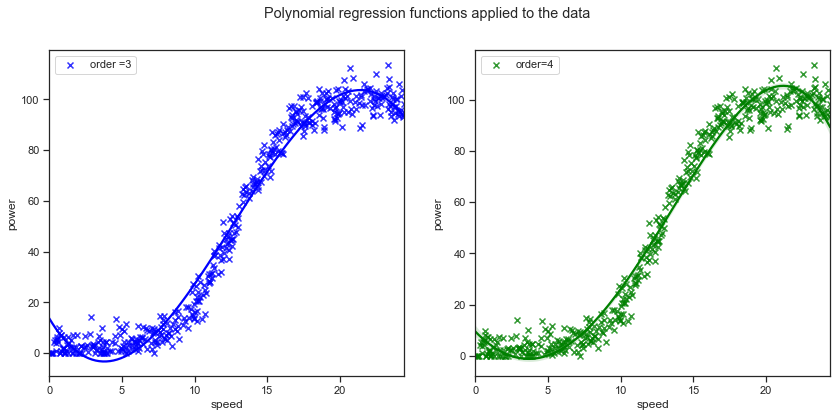

In [26]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))
x = "speed"
y = "power"

sns.regplot(x="speed", y="power", data=dfx, order=3, ax=axes[0], label="order =3", ci=False,marker="x", color="blue"); axes[0].legend()
sns.regplot(x="speed", y="power", data=dfx, order=4, ax=axes[1], label = "order=4",marker='x', color="green"); axes[1].legend()
plt.legend()
plt.suptitle("Polynomial regression functions applied to the data")
plt.show()

### Split data into training and test sets
Splitting your dataset is essential for an unbiased evaluation of prediction performance. The dataset can be split into two or three random subsets. 
- A training set:  used to train or fit your model. Training set are used to find the optimal weights or coefficients for linear regression, logistic regression, or neural networks.
- A validation set: subset used for unbiased model evaluation during hyperparameter tuning. For each set of hyperparameters, fit the model with the training set and assess it's performance with the validation set.
- A test set used for an unbiased evaluation of the final model. This should not be used for fitting or validating the model.
In less complex cases, when you don’t have to tune hyperparameters, it’s okay to work with only the training and test sets. [11]

Splitting a dataset can also be used for detecting if your model suffers from problems such as underfitting and overfitting. 

Underfitting usually arises when a model fails to capture the relationships among data. This can occur when  you try to represent non-linear relationships with a linear model. Overfitting occurs when a model has an excessively complex structure and learns both the existing relationships between the variables as well as the noise. Overfitted models usually fail to recognise the general trend of the data. 
While underfitted models are likely to have poor performance with both the training and testing dataset, overfitted models will usually have strong performance on the training dataset but will have poor performance on the unseen test set.
Scikit-learn has a module for splitting the data into training and test sets. The default split is 75% for the training set and 25% for the test set. The random state can be set to make the split reproducible. I initially did not use this but it makes it harder to compare the different machine learning models if you have a different training and test set for each.

#### Using scikit-learn to split the dataset into training and test subsets:
using `sklearn.model_selection.train_test_split`

In [28]:

# split into input and output columns

X, y = dfx.values[:, :-1], dfx.values[:, -1:]
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features

n_features = X_train.shape[1]

(356, 1) (119, 1) (356, 1) (119, 1)


#### Full dataset `df`:
To use the full dataset `df` including the zero power values change uncomment the line below

In [29]:
# split the dataset into input and output columns: df is the full dataset
#X, y = df.values[:, :-1], df.values[:, -1:]

#### Cleaned dataset `dfx`:

In [30]:
# split the dataset into input and output columns: dfx is the cleaned dataset
X, y = dfx.values[:, :-1], dfx.values[:, -1:]

In [31]:

# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]

(356, 1) (119, 1) (356, 1) (119, 1)


#### Transform the features of x 
Scikit-learns `PolynomialFeatures` can be used to add a cubic variable or a 4th degree variable to the dataset.
Once transformed the new polynomial features can be used with any linear model. The two regression models are developed alongside each other for convenience.

In [34]:
# using scikit-learn, set the order to 3 degrees to include a cubic 
# include_bias=False otherwise I end up with a column of zeros 
poly3 = PolynomialFeatures(degree=3, include_bias=False)
poly4 = PolynomialFeatures(degree=4, include_bias=False)

Note: While working on the web application I came back and updated the model to exclude the constant 1 as an extra term.  The model was generating 4 coefficients while I was working with 3 in the web application, the wind speed, wind speed squared and wind speed cubed values. The [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form `[a, b]`, the degree-2 polynomial features are `[1, a, b, a^2, ab, b^2]`.
Therefore I updated the model and set the `include_bias` to False.

In [35]:
# convert the inputs into a new set of variables, save as X_train_p3 to leave X_train untouched for later use
X_train_poly3 = poly3.fit_transform(X_train)
X_train_poly4 = poly4.fit_transform(X_train)

#### Look at the new features:

In [36]:
X_train_poly3

array([[8.08300000e+00, 6.53348890e+01, 5.28101908e+02],
       [2.47700000e+00, 6.13552900e+00, 1.51977053e+01],
       [1.57660000e+01, 2.48566756e+02, 3.91890348e+03],
       ...,
       [6.18100000e+00, 3.82047610e+01, 2.36143628e+02],
       [2.25200000e+00, 5.07150400e+00, 1.14210270e+01],
       [9.43400000e+00, 8.90003560e+01, 8.39629359e+02]])

In [37]:
X_train_poly4

array([[8.08300000e+00, 6.53348890e+01, 5.28101908e+02, 4.26864772e+03],
       [2.47700000e+00, 6.13552900e+00, 1.51977053e+01, 3.76447161e+01],
       [1.57660000e+01, 2.48566756e+02, 3.91890348e+03, 6.17854322e+04],
       ...,
       [6.18100000e+00, 3.82047610e+01, 2.36143628e+02, 1.45960376e+03],
       [2.25200000e+00, 5.07150400e+00, 1.14210270e+01, 2.57201528e+01],
       [9.43400000e+00, 8.90003560e+01, 8.39629359e+02, 7.92106337e+03]])

#### Transform the test sets:

In [38]:
# also need to transform the test data 
X_test_poly3 = poly3.fit_transform(X_test)
X_test_poly4 = poly4.fit_transform(X_test)

Linear regression can  now be implemented. This can be thought of as multiple linear regression as new variables in the form of x-squared and x-cubed (and x-quartic?) have been added to the model

#### Fit the model to the training data:

In [39]:
# call the linear regression model
model_poly3 = linear_model.LinearRegression()
model_poly4 = linear_model.LinearRegression()

In [40]:
# fit to the training data
model_poly3.fit(X_train_poly3, y_train)
model_poly4.fit(X_train_poly4, y_train)

LinearRegression()

#### Predict using the polynomial regression model:

In [41]:
# predict on the transformed test data
poly3_predictions = model_poly3.predict(X_test_poly3)
poly4_predictions = model_poly4.predict(X_test_poly4)

In [42]:
# Predicting a new result with Polymonial Regression
model_poly3.predict(poly3.fit_transform([[0]]))

array([[14.35877751]])

In [43]:
# Predicting a new result with Polymonial Regression
model_poly4.predict(poly4.fit_transform([[0]]))

array([[9.94417577]])

In [44]:
model_poly3.predict(poly3.fit_transform([[12]]))

array([[45.01454843]])

In [45]:
# Predicting a new result with Polymonial Regression
model_poly4.predict(poly4.fit_transform([[12]]))

array([[43.28996568]])

#### Get the coefficients

In [46]:
# get the coefficiets
model_poly3.coef_

array([[-9.69965794,  1.49732   , -0.03967732]])

In [47]:
# get the coefficiets
model_poly4.coef_

array([[-5.98949605e+00,  8.11385527e-01,  3.98058010e-03,
        -8.92082165e-04]])

In [48]:
# get the intercept
model_poly3.intercept_

array([14.35877751])

In [49]:
# get the intercept
model_poly4.intercept_

array([9.94417577])

#### Visualise the polynomial regression results:
The scatter-plot can visualise the polynomial regression results on the test dataset can compared to the actual datapoints.

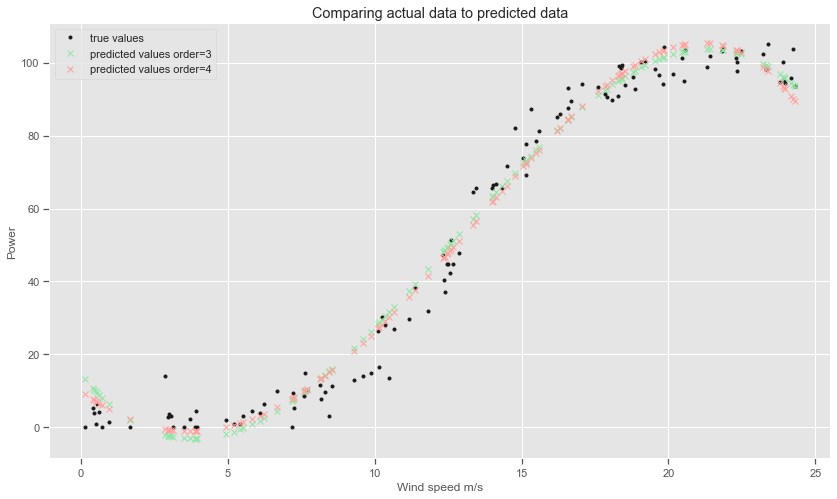

In [50]:
# create the plot
plt.style.use('ggplot')
# Plot size.
plt.rcParams['figure.figsize'] = (14, 8)
plt.title('Comparing actual data to predicted data')
plt.plot(X_test, y_test, 'k.', label="true values")
plt.plot(X_test, poly3_predictions, 'gx', label="predicted values order=3")
plt.plot(X_test, poly4_predictions, 'rx', label="predicted values order=4")
plt.xlabel("Wind speed m/s")
plt.ylabel("Power")
plt.legend()

plt.show()

### Evaluate the model

Scikit-learn has a metrics module that can be used to evaluate the model.
[sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
The coefficient of determination $R^2$ is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).[16]
It shows how good the model is at explaining the behaviour of the dependent variable. The coefficient of determination is the proportion of variation in the dependent variable power that is explained by the regression line and the independent variable wind speed. It is a better indicator of the strength of a linear relationship than the correlation coefficient as it identifies the percentage of variation of the dependent variable that is directly attributable to the variation of the independent variable. 

The model can be evaluated using the mean squared error. It calculates the average distance our data points are from the model.  
The mean squared error could be further lowered by adding extra polynomials to the model. However you are then in danger of overfitting the model where the model will fail to recognise the general trend. The simple linear model cleared underfit the data. The seaborn regression plots with a 4th order polynomial earlier did show a slightly better fit for speed values under 5 metres per second whereas the 3rd order polynomial is underpredicting and overfitting for sections of the curve. Polynomial regression can be very sensitive to outliers and even a few outliers could seriously affect the results. In addition there are unfortunately fewer model validation tools for the detection of outliers in nonlinear regression than there are for linear regression. [16]

The root mean squared error is the square root of the average of squared differences between prediction and actual observation.  It is a standard way to measure the error of a model in predicting quantitative data.

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
# The coefficients
print('Coefficients: \n', model_poly3.coef_)

Coefficients: 
 [[-9.69965794  1.49732    -0.03967732]]


In [53]:
print("Results from 3rd degree polynomial regression:")
print('Mean squared error: %.2f' % mean_squared_error(y_test,poly3_predictions ))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, poly3_predictions))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test,poly3_predictions )))

Results from 3rd degree polynomial regression:
Mean squared error: 33.32
Coefficient of determination: 0.98
Root Mean Squared Error: 5.77


In [54]:
print("Results from 4th degree polynomial regression:")
print('Mean squared error: %.2f' % mean_squared_error(y_test,poly4_predictions ))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, poly4_predictions))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test,poly4_predictions )))

Results from 4th degree polynomial regression:
Mean squared error: 30.80
Coefficient of determination: 0.98
Root Mean Squared Error: 5.55


The mean squared error for the 4th order polynomial did fall a little compared to the polynomial using 3 degrees. The R-squared value does not seem to have changed much though. The curves above show that they both overestimate the power values for very low wind speed values. For the slightly higher wind speed values the curve predicts negative values of power. Fitting higher order polynomials might pick up more of the trends in the training data but would be unlikely to work very well with new data. 

In [55]:
# Predicting a new result with Polymonial Regression
# need to transform the data to be predicted
model_poly3.predict(poly3.fit_transform([[20]]))

array([[101.8750371]])

In [56]:
# need to transform the data to be predicted
model_poly4.predict(poly4.fit_transform([[20]]))

array([[103.81995991]])

In [57]:
# Predicting a new result with Polymonial Regression
model_poly3.predict(poly3.fit_transform([[24.4]]))

array([[92.74766278]])

In [58]:
# Predicting a new result with Polymonial Regression
model_poly3.predict(poly3.fit_transform([[3]]))

array([[-2.33560405]])

### Save the model for use in the Web application
This project also requires a web service to be developed that will respond with predicted power values based on speed values sent as HTTP requests. Therefore I need to save the model for use outside this notebook.

For the polynomial regression model, there is the option of  using Python’s built-in persistence model `pickle`. The [scikit-learn documents](
https://scikit-learn.org/stable/modules/model_persistence.html) recommend using joblib’s replacement of pickle (dump & load), which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators, but can only pickle to the disk and not to a string.



In [59]:
#from joblib import dump, load
#dump(model_poly3, 'models/model_poly3.joblib') 
#dump(model_poly4, 'models/model_poly4.joblib') 

['models/model_poly4.joblib']

In [60]:
#dump(model_poly3, 'models/model_poly3.pkl') 
#dump(model_poly4, 'models/model_poly4.pkl') 

['models/model_poly4.pkl']

In [61]:
wind12 = poly3.fit_transform([[12]])
wind12

array([[  12.,  144., 1728.]])

In [62]:
windp4_12 = poly4.fit_transform([[12]])
windp4_12

array([[1.2000e+01, 1.4400e+02, 1.7280e+03, 2.0736e+04]])

In [63]:
model_poly4.predict(windp4_12)

array([[43.28996568]])

In [64]:
wind12 = [[12, 12**2, 12**3]]
wind12 =np.array(wind12)

In [65]:
model_poly3.predict(wind12)

array([[45.01454843]])

In [66]:
wind3 = [[3, 3**2, 3**3]]
wind3 = np.array(wind3)
model_poly3.predict(wind3)

array([[-2.33560405]])

The polynomial curve does quite a good job but similarly to the MLP below, it predicts power values for values over 24.4 which is the cut-off range. 
Also the transformation has to be taken into account when taking in new values from the end user.

---
## ## Machine Learning Model 2: Artificial Neural Network

For my second machine learning model I will implement an artificial neural network using the `tf.keras` API.
In addition to the lecture videos I followed several tutorials in particular those by MachineLearningMastery.com [20] as well as the Tensorflow-Keras documentation and other tutorials documented in the references section below. TensorFlow is the premier open-source deep learning framework developed and maintained by Google. Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.[21] 

A Multilayer Perceptron model (MLP) is a standard fully connected neural network model. It is made up of one or more (dense) layers of nodes where each node is connected to all outputs from the previous layer and the output of each node is connected to all the inputs for the nodes in the next layer. This model is suitable for tabular data and can be used for three predictive modeling problems being binary classification, multiclass classification, and regression.[20]

Machine learning is the science of getting computers to act without being explicitly programmed. Artificial neural networks are a class of machine-learning algorithms  that are used to model complex patterns in datasets through the use of multiple hidden layers and non-linear activation functions. They are designed to simulate the way the human brain analyses and processes information. The computer learns to perform some task by analyzing training examples.

>An artificial neural network (ANN) is the piece of a computing system designed to simulate the way the human brain analyzes and processes information. It is the foundation of artificial intelligence (AI) and solves problems that would prove impossible or difficult by human or statistical standards. ANNs have self-learning capabilities that enable them to produce better results as more data becomes available.[17]

>Neural nets are a means of doing machine learning, in which a computer learns to perform some task by analyzing training examples. Modeled loosely on the human brain, a neural net consists of thousands or even millions of simple processing nodes that are densely interconnected. Most of today’s neural nets are organized into layers of nodes, and they’re “feed-forward,” meaning that data moves through them in only one direction. An individual node might be connected to several nodes in the layer beneath it, from which it receives data, and several nodes in the layer above it, to which it sends data. To each of its incoming connections, a node will assign a number known as a “weight.” When the network is active, the node receives a different data item — a different number — over each of its connections and multiplies it by the associated weight. It then adds the resulting products together, yielding a single number. If that number is below a threshold value, the node passes no data to the next layer. If the number exceeds the threshold value, the node “fires,” which in today’s neural nets generally means sending the number — the sum of the weighted inputs — along all its outgoing connections.
When a neural net is being trained, all of its weights and thresholds are initially set to random values. Training data is fed to the bottom layer — the input layer — and it passes through the succeeding layers, getting multiplied and added together in complex ways, until it finally arrives, radically transformed, at the output layer. During training, the weights and thresholds are continually adjusted until training data with the same labels consistently yield similar outputs.[18]


A neural network takes an input and passes it through multiple layers of hidden neurons. These hidden neurons can be considered as mini-functions with coefficients that the model must learn. The neural network will output a prediction that represents the combined input of all the neurons. Neural networks are trained iteratively using optimization techniques such as gradient descent. 

After each cycle of training, an error metric is calculated based on the difference between the prediction and the target. The derivatives of this error metric are calculated and propagated back through the network using a technique called backpropagation. Each neuron’s coefficients (weights) are then adjusted relative to how much they contributed to the total error. This process is repeated iteratively until the network error drops below an acceptable threshold. [19]

To use artificial neural networks on a dataset all variables need to be first encoded into floating point numbers. Outputs can be reverse decoded later. A neuron takes a group of weighted inputs, applies an activation function and returns an output. The inputs to a neuron can be features from a training set or the outputs from the previous layer's neurons. The weights and bias are the parameters of the model. The initial weights are often set to small random values and can be adjusted to get the neural network to perform better. Weights are applied along the inputs as they travel along the 'synapses' (the connection between two neurons) to reach the neuron. The neuron then applies an activation function to the sum of the weighted inputs from each incoming synapse and passes the result to all the neurons in the next layer.
Weights are applied to each connection. These are values that control the strength of the connection between two neurons.  Inputs are usually multiplied by weight that define how much influence the input will have on the output. The lower the weight the lower the importance of the connection while the higher the weight the higher the importance of the connection. When the inputs are transmitted between the neurons, the weights are applied to  the inputs as well as an additional value known as the bias. The bias are additional constant terms that are attached to each neuron and are added to the weighted input before the activation function is applied. *Bias terms help models represent patterns that do not necessarily pass through the origin.* [19] Bias terms must also be learned by the model.

The input layer of a neural network will hold the data to train the model. Neural networks can have several input features each represented by a neuron that represents the unique attributes in the dataset. This dataset has a single input feature, the wind speed in metres per second.

The neural network can have one or more hidden layers between the input layer and the output layer. The hidden layers applies an activation function before passing on the results to the next layer. Hidden layers can be fully connected or dense layers where each neuron receives inputs from all the neurons in the previous layer and sends its output to each neuron in the next layer. Alternatively with a convolutional layer the neurons will send their output to only some of the neurons in the next layer. The output layer is the final layer in the neural network and receives its input from the previous hidden layer. It can also apply an activation function and returns an output. The output represents the prediction from the neural network.

With neural networks the aim is to get a high value assigned to the correct output. If the neural network misclassifies an output label then it is fed back into the algorithm, the weights are changed a little so that the correct output is predicted the next time and this will keep changing until it gets the correct output. 
The starting values for the weights are usually random values and which updated over time to achieve the expected output using an algorithm such as gradient descent (or stochastic gradient descent `sgd`) or some other algorithm. 

The input to a neuron is the sum of the weighted outputs from all the neurons in the previous layer. Each input is multiplied by the weight associated with the synapse or connnection connecting  the input to the current neuron.
If there are `n`  inputs or neurons in the previous layer then each neuron in the current layer will have `n` distinct weight with one weight for each connection.
For multiple inputs this is $x_1w_1+x_2w_2+x_3w_3$ which is the same equation as used for linear equation. A neural network with a single neuron is actually the same as linear regression except that the neural network post-processes the weighted inputs with an activation function. [19]

There are activation function inside each layer of a neural network which modifies the inputs they receive before passing them onto the next layer. Activation functions allow a neural network to model complex non-linear functions. In order to be able to use gradient descent the outputs need to have a slope with which to calculate the error derivative with respect to the weights. If the neuron only outputted a 0 or 1 then this doesn't tell us in what direction the weights need to be updated to reduce the error. 

A medium article [22] provides some background on activation functions which I refer to here:
An artificial neuron calculates a weighted sum of its input, adds a bias and then decides whether it should be fired or not. $Y = \sum{(\text{weight} * \text{input})} + \text{bias}$.
The value of Y can be anything from -infinity to + infinity and the neuron does not really know the bounds of the value. To decide whether the neuron should fire or not the activation function checks the $Y$ value produced by the neuron and decides whether outside connections should consider this neuron as activated (fired) or not.
With a threshold based activation function, if the value of Y is above a certain value then it can be declared as activated and otherwise not. The output is 1 (activated) when the value is greater than the threshold and 0 otherwise. This is a step function which has drawbacks being used as an activation function when the response is not a binary yes or no. 
A linear activation function $A=cX$ is a straight line function where activation is proportional to input (which is the weighted sum from neurons). In this way it will give a range of activations rather than just binary activations. Nuerons can be connected and if more than one fire then you can take the max and make a decision based on that. The derivative w.r.x is c which means that the gradient has no relationship with X. The descent is going to be on a constant gradient. If there is an error in prediction the changes made by back propagation is constant and not depending on the change in input delta(x).
Another problem concerns the connected layers where each layer is activated by a linear function. 
That activation in turn goes into the next level as input and the second layer calculates weighted sum on that input and it in turn, fires based on another linear activation function.
No matter how many layers we have, if all are linear in nature, the final activation function of last layer is nothing but just a linear function of the input of first layer. Therefore two or more layers can be replaced by a single layer. The whole network then is equivalent to  a single layer with linear activation.

The sigmoid function is smooth and looks somewhat like a step function. It is nonlinear in nature and therefore combinations of layers are also non-linear which means that layers can be stacked. It will also give non-binary activations unlike the step function. It has a smooth gradient.
Between X values -2 to 2, the Y values are very steep. This means that any small changes in the values of X in that region will cause values of Y to change significantly. This means this function has a tendency to bring the Y values to either end of the curve. It tends to bring the activations to either side of the curve making clear distinctions on prediction. Another advantage over linear function is that the output of the activation function is always going to be in range (0,1) compared to (-inf, inf) of linear function and therefore the activations are bound in a range. 
Sigmoid functions are one of the most widely used activation functions today. The problems with them is that towards either end of the sigmoid function, the Y values tend to respond less to changes in X. This means that the gradient at that region is going to be small. It gives rise to a problem of “vanishing gradients”. When the activations reach near the “near-horizontal” part of the curve on either sides, the gradient is small or has vanished (cannot make significant change because of the extremely small value). The network refuses to learn further or is drastically slow (depending on use case and until gradient /computation gets hit by floating point value limits ). There are ways to work around this problem and sigmoid is still very popular in classification problems.
The article also looked at the Tanh activation functions which is a scaled sigmoid function and the ReLu function which gives an output x if x is positive and 0 otherwise. These are both non-linear functions.
The same article suggest how to choose the correct activation function for your model. When you know the function you are trying to approximate has certain characteristics, you can choose an activation function which will approximate the function faster leading to faster training process. 

The loss function or cost function tells us how well the model predicts for a given set of parameters. It has its own curve and derivative and the slope of this curve informs how to change the parameters to make the model more accurate. The lost or cost functions for regression problems is usually the mean squared error MSE. Other loss functions would be used for classification problems.

Once the neural network is trained and is stable, if a new datapoint that it was not trained on is provided to it the neural network should be able to correctly classify it.

### Machine Learning Model  2: A neural network

### The data:
I am using the dataframe `dfx` where some of the zero values were dropped.
I can alternatively try using the `df` dataframe consisting of all 500 rows.

In [87]:
dfx.describe()

,speed,power
count,475.000000,475.000000
mean,12.440971,50.541667
std,7.101231,41.171815
min,0.000000,0.000000
25%,6.293500,6.737500
50%,12.538000,47.282000
75%,18.531500,94.017500
max,24.399000,113.556000


### Split the data into training and test sets

The ideal machine-learning model is end to end and therefore the preprocessing should be part of the model as much as possible to make the model portable for production. However I have already split the dataset earlier for the polynomial regression model and need to be able to compare the models.

In [ ]:
dfx.values.shape

In [88]:

# split into input and output columns

X, y = dfx.values[:, :-1], dfx.values[:, -1:]
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features

n_features = X_train.shape[1]

(356, 1) (119, 1) (356, 1) (119, 1)


In [89]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]

(356, 1) (119, 1) (356, 1) (119, 1)


#### Full dataset `df`:
To apply the model to the full dataset uncomment the code below.

In [90]:
# split the dataset into input and output columns: df is the full dataset
#X, y = df.values[:, :-1], df.values[:, -1:]
# split into train and test datasets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
#n_features = X_train.shape[1]
# split the dataset into input and output columns: df is the full dataset
#X, y = df.values[:, :-1], df.values[:, -1:]

##### To normalise or not.
I initially followed some tutorials that used scikit-learn for scaling or normalising data and now I see that this will be a problem on the web app as the data taken in would have to have the scaling or normalisation applied as the training data. Keras does have some preprocessing layers including the `Normalization` layer for feature normalization.
The neural network model I first developed was a multi perceptron neural network on the unscaled data. The predictions did not compare badly at all to the actual data and  out performed the polynomial regression models so I have excluded this step for now. 

A machine learning model has a life-cycle with 5 steps:[20]

[Keras documentation](https://www.tensorflow.org/guide/keras/sequential_mode) 

### 1. Define the model: 
Select the type of model and choose the architecture or network topology. Define the number of layers, configure each layer with a number of nodes and activation function, connect the layers together into a cohesive model.
A layer is a simple input-output transformation while a model is a directed acyclic graph of layers. It is like a bigger layer consisting of many sub-layers that can be trained via exposure to data. According to any tutorials I came across, determining the correct number of layers to use is a matter of trial and error really. Generally you need a network large enough to capture the structure of the problem.

The input layer is first defined then you chain layer transformations on top of the inputs until the final output.
All layers in Keras need to know the shape of their inputs in order to be able to create weights. The shape of the weights depends on the shape of their inputs. The `Input` object is not considerd a layer.
The visible layer of the network is defined by the input shape argument on the first hidden layer. In the dataset for this project this will be `(1,)` as there is only a single input variable wind speed. The model will then expect the input for one sample to be a vector of 1 number.

There are two main models that are provided in the tensorflow-keras API. A `Sequential` model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. A `Sequential` model is not appropriate for models with multiple inputs or outputs. A sequential neural network is built up in sequential layers. It adds layers to the model one by one in a linear manner, from input to output. I will be using the `Sequential` model for this project. A `Sequential` model is created by passing  a list of layers to the Sequential constructor `model = keras.Sequential` or by incrementally adding the layers using the `model.add()` method.
There is also a `Functional` model which is more complex but more flexible than the `Sequential` model. For this you need to explicitly connect the output of one layer to the input of another layer. Each connection is specified.

Fully connected layers are defined using the `Dense` class - `Dense` refers to the layer being densely connected to the previous layer. Every node in the previous layer is connected to everything in the current layer.
The first line of code that adds the first Dense layer does 2 things, defines the input or visible layer and the first hidden layer. The number of neurons or nodes in the layer as the first argument and specify the activation function using the `activation` argument. We were advised to use the Sigmoid activation function for this project so I will do this.  A `Sigmoid` layer is used on the outer layer to ensure the network output is between 0 and 1. 
According to the tutorials, Sigmoid and Tanh activation functions were the preferred choice  for all layers before but that these days better performance is achieved using the `rectified linear unit` or `ReLU` activation function.

Initializers define the way to set the initial random weights of Keras layers. The `kernel_initializer` and `bias_initializer` parameter refers to the distribution or function to use for initialising the weights. Initializers available include `RandomNormal` class , `RandomUniform` class, a `Zeros` class, a `Ones` class. `GlorotNormal` draws samples from a truncated normal distribution centered on 0. `GlorotUniform` draws samples from a uniform distribution within some limits. 

Once the layers have been defined that turn the inputs into outputs, instantiate a `model` object.

In [67]:
# Define a model
model = kr.models.Sequential()
# Here I played around with the kernel initialiser but it did not do much good
initializer = kr.initializers.RandomUniform(minval=0., maxval=24.4)
model.add(kr.layers.Dense(20, input_shape=(1,), activation='sigmoid', kernel_initializer=initializer, bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(20, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

### 2. Compile the model
Once the model is defined, it can be compiled or built using the `compile()` method passing in the selected loss functions and optimizer functions.  For this project we use the mean squared error as the cost function we are considering a regression problem.
Loss functions such as  `MeanSquaredError` computes the mean of squares of errors between labels and predictions.
There are many more listed in the [keras losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) documentation.

The optimizer performs the optimisation procedure such as stochastic gradient descent or `Adam` . Adam is a modern variation of stochastic gradient descent method which automatically tunes itself and gives good results in a wide range of problems. The optimizer can be specified as a string for a known optimizer class such as `sgd` for stochastic gradient descent or else you can configure an instance of the [optimizer classes](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) to use.
`sgd` is a gradient descent (with momentum) optimizer. It has a default learning rate of 0.01
The update rule is ` w = w - learning_rate * g` for parameter `w` with  gradient `g` when momentum is 0.
The `learning_rate` defaults to 0.001 in the Adam optimizer. 

You can also  select some performance metrics to keep track of and report during the model training process
Metrics to evaluate predictions from the model include `Accuracy` to calculates how often predictions equal labels, `AUC`  computes the approximate area under the curve,  `FalseNegatives` calculates the number of false negatives and `FalsePositives`  calculates the number of false positives, `Precision` computes the precision of the predictions with respect to the labels. 

In [68]:
# 
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


### 3. Fit the model
- Once the model has been compiled, fit the model to the data using `fit()`.
To fit the model you need to select the training configuration such as the number of epochs which are loops or iterations through the training dataset. The batch size is the number of samples in an epoch used to estimate model error. By passing in for example 10 at a time instead of 1 at a time can have a smoothing effect.

Training applies the chosen optimization algorithm to minimize the chosen loss function and updates the model using the backpropagation of error algorithm. This can be slow depending on the complexity of the model, the size of the training dataset and the hardware being used.
The `fit` call returns a history object which records what happens over the course of the training.
- The `history.history` dict contains per-epoch timeseries of metrics values.
- Validation data can be passed to `fit()` to monitor the validation loss & validation metrics which get reported at the end of each epoch.

When passing data to the built-in training loops of a model, NumPy arrays can be used if the data is small and fits in memory or `tf.data.Dataset` objects. The dataset here is only 500 rows.

#### Train the model on the data

In [69]:
# fit the model

#history=model.fit(X_train, y_train, validation_data =(X_test, y_test),epochs=500, batch_size=10) #verbose=0
history = model.fit(X_train, y_train, epochs=500, batch_size=10, validation_split=0.2)

Epoch 1/500
29/29 [==============================] - 0s 5ms/step - loss: 4111.8774 - val_loss: 4086.5017
Epoch 2/500
29/29 [==============================] - 0s 2ms/step - loss: 4014.5208 - val_loss: 3996.5625
Epoch 3/500
29/29 [==============================] - 0s 2ms/step - loss: 3932.4692 - val_loss: 3921.8459
Epoch 4/500
29/29 [==============================] - 0s 2ms/step - loss: 3865.8767 - val_loss: 3859.6396
Epoch 5/500
29/29 [==============================] - 0s 2ms/step - loss: 3809.5769 - val_loss: 3808.5752
Epoch 6/500
29/29 [==============================] - 0s 2ms/step - loss: 3761.7170 - val_loss: 3761.2412
Epoch 7/500
29/29 [==============================] - 0s 2ms/step - loss: 3717.8782 - val_loss: 3719.7473
Epoch 8/500
29/29 [==============================] - 0s 2ms/step - loss: 3677.6736 - val_loss: 3680.3108
Epoch 9/500
29/29 [==============================] - 0s 2ms/step - loss: 3639.5405 - val_loss: 3643.2310
Epoch 10/500
29/29 [==============================] - 0

29/29 [==============================] - 0s 2ms/step - loss: 1950.2157 - val_loss: 1929.9939
Epoch 79/500
29/29 [==============================] - 0s 2ms/step - loss: 1926.0704 - val_loss: 1905.9230
Epoch 80/500
29/29 [==============================] - 0s 2ms/step - loss: 1900.8301 - val_loss: 1880.7290
Epoch 81/500
29/29 [==============================] - 0s 2ms/step - loss: 1873.6477 - val_loss: 1854.2435
Epoch 82/500
29/29 [==============================] - 0s 2ms/step - loss: 1845.8643 - val_loss: 1827.4395
Epoch 83/500
29/29 [==============================] - 0s 2ms/step - loss: 1818.3369 - val_loss: 1800.2089
Epoch 84/500
29/29 [==============================] - 0s 2ms/step - loss: 1789.6825 - val_loss: 1770.9191
Epoch 85/500
29/29 [==============================] - 0s 2ms/step - loss: 1757.2000 - val_loss: 1738.4393
Epoch 86/500
29/29 [==============================] - 0s 2ms/step - loss: 1721.8990 - val_loss: 1703.6525
Epoch 87/500
29/29 [==============================] - 0s 2m

29/29 [==============================] - 0s 2ms/step - loss: 494.6125 - val_loss: 498.0856
Epoch 156/500
29/29 [==============================] - 0s 2ms/step - loss: 485.0479 - val_loss: 488.9812
Epoch 157/500
29/29 [==============================] - 0s 2ms/step - loss: 476.3763 - val_loss: 479.9926
Epoch 158/500
29/29 [==============================] - 0s 2ms/step - loss: 466.8524 - val_loss: 471.2653
Epoch 159/500
29/29 [==============================] - 0s 2ms/step - loss: 457.6520 - val_loss: 461.6764
Epoch 160/500
29/29 [==============================] - 0s 2ms/step - loss: 448.5144 - val_loss: 452.6372
Epoch 161/500
29/29 [==============================] - 0s 2ms/step - loss: 439.9575 - val_loss: 443.8704
Epoch 162/500
29/29 [==============================] - 0s 2ms/step - loss: 431.0776 - val_loss: 435.9428
Epoch 163/500
29/29 [==============================] - 0s 2ms/step - loss: 422.6501 - val_loss: 427.9921
Epoch 164/500
29/29 [==============================] - 0s 2ms/step - 

29/29 [==============================] - 0s 2ms/step - loss: 85.3748 - val_loss: 94.8748
Epoch 234/500
29/29 [==============================] - 0s 2ms/step - loss: 83.1721 - val_loss: 92.1122
Epoch 235/500
29/29 [==============================] - 0s 2ms/step - loss: 81.1435 - val_loss: 90.0617
Epoch 236/500
29/29 [==============================] - 0s 2ms/step - loss: 79.2254 - val_loss: 87.9436
Epoch 237/500
29/29 [==============================] - 0s 2ms/step - loss: 77.3348 - val_loss: 86.2521
Epoch 238/500
29/29 [==============================] - 0s 2ms/step - loss: 75.6166 - val_loss: 84.6226
Epoch 239/500
29/29 [==============================] - 0s 2ms/step - loss: 73.6544 - val_loss: 82.0176
Epoch 240/500
29/29 [==============================] - 0s 2ms/step - loss: 72.1174 - val_loss: 80.0088
Epoch 241/500
29/29 [==============================] - 0s 2ms/step - loss: 69.8407 - val_loss: 79.0679
Epoch 242/500
29/29 [==============================] - 0s 2ms/step - loss: 68.4688 - va

29/29 [==============================] - 0s 2ms/step - loss: 19.0026 - val_loss: 19.5809
Epoch 313/500
29/29 [==============================] - 0s 2ms/step - loss: 18.5202 - val_loss: 19.7463
Epoch 314/500
29/29 [==============================] - 0s 2ms/step - loss: 18.4783 - val_loss: 19.4222
Epoch 315/500
29/29 [==============================] - 0s 2ms/step - loss: 18.3974 - val_loss: 18.9753
Epoch 316/500
29/29 [==============================] - 0s 2ms/step - loss: 18.2709 - val_loss: 19.2454
Epoch 317/500
29/29 [==============================] - 0s 2ms/step - loss: 18.0261 - val_loss: 18.6031
Epoch 318/500
29/29 [==============================] - 0s 2ms/step - loss: 18.3435 - val_loss: 18.6886
Epoch 319/500
29/29 [==============================] - 0s 2ms/step - loss: 18.0169 - val_loss: 18.7510
Epoch 320/500
29/29 [==============================] - 0s 2ms/step - loss: 18.0064 - val_loss: 18.2217
Epoch 321/500
29/29 [==============================] - 0s 2ms/step - loss: 17.9009 - va

29/29 [==============================] - 0s 2ms/step - loss: 16.8587 - val_loss: 16.3992
Epoch 392/500
29/29 [==============================] - 0s 2ms/step - loss: 16.7044 - val_loss: 16.7483
Epoch 393/500
29/29 [==============================] - 0s 3ms/step - loss: 16.6937 - val_loss: 15.9702
Epoch 394/500
29/29 [==============================] - 0s 2ms/step - loss: 16.5767 - val_loss: 16.9143
Epoch 395/500
29/29 [==============================] - 0s 2ms/step - loss: 16.6317 - val_loss: 16.3877
Epoch 396/500
29/29 [==============================] - 0s 2ms/step - loss: 16.9836 - val_loss: 16.9109
Epoch 397/500
29/29 [==============================] - 0s 2ms/step - loss: 16.4753 - val_loss: 16.1505
Epoch 398/500
29/29 [==============================] - 0s 2ms/step - loss: 16.6116 - val_loss: 15.8361
Epoch 399/500
29/29 [==============================] - 0s 2ms/step - loss: 16.6213 - val_loss: 16.1834
Epoch 400/500
29/29 [==============================] - 0s 2ms/step - loss: 16.5994 - va

29/29 [==============================] - 0s 4ms/step - loss: 16.5390 - val_loss: 16.1737
Epoch 471/500
29/29 [==============================] - 0s 3ms/step - loss: 16.4500 - val_loss: 16.2776
Epoch 472/500
29/29 [==============================] - 0s 3ms/step - loss: 16.4969 - val_loss: 15.9401
Epoch 473/500
29/29 [==============================] - 0s 3ms/step - loss: 16.6310 - val_loss: 15.9367
Epoch 474/500
29/29 [==============================] - 0s 3ms/step - loss: 16.6760 - val_loss: 16.2784
Epoch 475/500
29/29 [==============================] - 0s 4ms/step - loss: 16.9740 - val_loss: 16.2343
Epoch 476/500
29/29 [==============================] - 0s 4ms/step - loss: 16.6430 - val_loss: 15.9192
Epoch 477/500
29/29 [==============================] - 0s 4ms/step - loss: 16.4349 - val_loss: 16.8391
Epoch 478/500
29/29 [==============================] - 0s 4ms/step - loss: 16.7161 - val_loss: 16.3777
Epoch 479/500
29/29 [==============================] - 0s 4ms/step - loss: 16.3771 - va

### 4. Evaluate the model
After `fit()` you can evaluate the performance and generate predictions on new data using `evaluate()`.
This is where the holdout dataset comes into play, data that is not used in the training of the model so you can get an unbiased estimate of the performance of the model when making predictions on new data.

#### Plotting the learning curve

You can also plot the model learning curves which plot the performance of the neural network model over time. It helps determine if the model is learning well and whether it is underfitting or overfitting the training set. To do this you need to update the call to to the `fit` function to include a reference to a validation dataset which is a portion of the training dataset not used to fit the model but instead used to evaluate the performance of the model during training. The fit function will then return a history object containing a trace of performance metrics recorded at the end of each training epoch. A learning curve is a plot of the loss on the training dataset and the validation dataset.
Learning curves of mean squared error  on the train and test set at the end of each training epoch are graphed below using line plots. These learning curves give an indication of the dynamics while learning the model.
The learning curve below shows that the loss from the validation data is very close to the loss from the training data. This can also be seen by the print outs for each epoch above. The loss falls dramatically over the first 100 epochs and then the decrease stabilises.

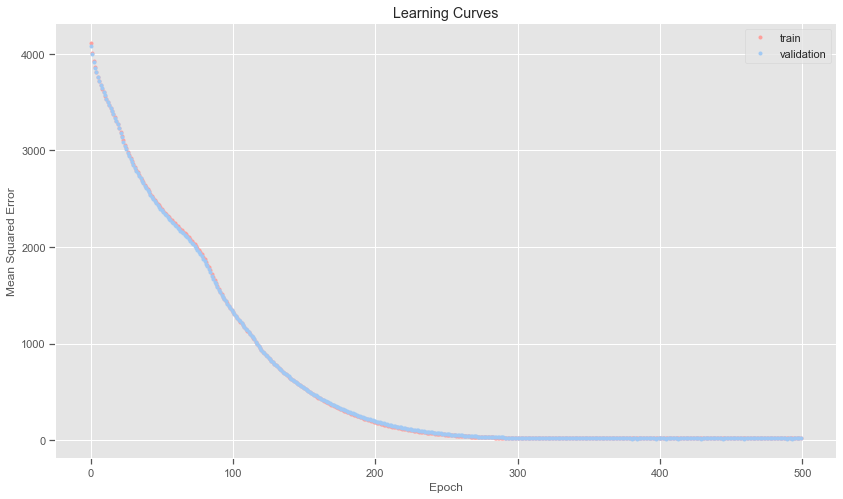

In [70]:
#history = model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=0, validation_split=0.3)
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(history.history['loss'], 'r.',label='train')
plt.plot(history.history['val_loss'], 'b.',label='validation')
plt.legend()
plt.show()

The ideal loss is is zero and the ideal accuracy is 1.0 or 100%. The root mean squared error is quite low overall. The loss is higher though on the test set than on the training data. However over almost 500 data point this does not look too bad at all.

#### Evaluate() the performance of the model on new data:

In [79]:
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse, test_mse))

Train MSE: 16.808, Test MSE: 19.350


In [80]:

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Training data RMSE: %.3f, Test data RMSE: %.3f' % (train_rmse, test_rmse))


Training data RMSE: 4.100, Test data RMSE: 4.399


### 5. Make predictions using the neural network model
This is the final stage of the life cycle where you take values that you don't have target values and make a prediction using the model
- Generate numPy arrays of predictions using `predict()`.
`predictions = model.predict(val_dataset)`



### Predictions using the neural network model:
Run each x value through the neural network.

In [81]:
model_predictions = model.predict(X_test)

### Compare actual data to predictions on test set

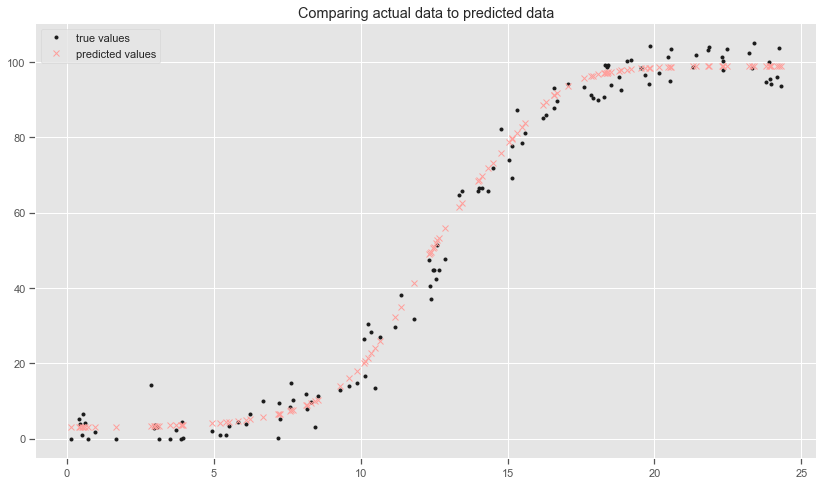

In [82]:
plt.title('Comparing actual data to predicted data')
plt.plot(X_test, y_test, 'k.', label="true values")
plt.plot(X_test, model_predictions, 'rx', label="predicted values")

plt.legend()
plt.show()

In [83]:
model.predict([0])

array([[4.254731]], dtype=float32)

In [84]:
model.predict([24.5])

array([[99.014435]], dtype=float32)


The neural network model is over-predicting the power value when the wind speed exceeds the cut-off rates. I guess the model does not actually know this bit of information! I removed these observations from the training data as the dataset and research suggests that than for safety reasons the turbines are turned off when wind speed exceeds 24.4 metres per second.
I need to take this into account in the prediction web service application. The neural network model is also predicting power values when the wind speed is zero. This is not really a problem as you would not expect to be predicting the power output for no wind.
I did try adding extra layers and playing around with the parameters but to no avail. This makes the model more computationally expensive.

Overall the model is better at predicting power for the lower values of wind speed than the polynomial regression models. The plot shows that the predictions go right through the test data points and captures the overall trend.

I did change the kernel_initializer to random_uniform and specified a min and max values in the first hidden layer as I thought this might help but the model still predicts a non-zero values for zero wind speeds and for speeds greater than the cut-off wind speed of 24.4 metres per second. I need to know some more about how the kernel initialisers actually work.

In [102]:
#model.predict([26])
#model.predict([23.5])
#model.predict([0])
#model.predict([12])

array([[100.30588]], dtype=float32)

#### Save the model for use in the web app

Instead of having to retrain the model each time, it can be saved to a file using the save() function on the model and loaded later to make predictions using the load_model() function. The model is saved in H5 format, an efficient array storage format. For this I need the h5py library.

In [101]:
#model.save('models/model.h5')

### Variations of the same artificial neural network model:
Here I tried out changing the kernel_initialiser to using the glorot_uniform initialiser. More neurons were added in the second layer. The loss does fall quicker as can be seen from the printouts as well as the learning curve. 
The difference in cost between the different versions of the neural network models is very small. 
It does seem as if all roads lead to Rome!

#### Define a model:

In [87]:
# Define a model
model2 = kr.models.Sequential()

model2.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

model2.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model2.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

#### Compile the model

In [88]:
# compile the model
model2.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


#### Fit a model

In [89]:
history2=model2.fit(X_train, y_train, validation_split=0.2,epochs=500, batch_size=10) #verbose=0

Epoch 1/500
29/29 [==============================] - 0s 5ms/step - loss: 4015.1272 - val_loss: 3949.0095
Epoch 2/500
29/29 [==============================] - 0s 2ms/step - loss: 3836.1064 - val_loss: 3765.0317
Epoch 3/500
29/29 [==============================] - 0s 3ms/step - loss: 3664.4727 - val_loss: 3603.3955
Epoch 4/500
29/29 [==============================] - 0s 3ms/step - loss: 3520.8818 - val_loss: 3478.7874
Epoch 5/500
29/29 [==============================] - 0s 3ms/step - loss: 3409.5623 - val_loss: 3376.7690
Epoch 6/500
29/29 [==============================] - 0s 2ms/step - loss: 3316.9539 - val_loss: 3288.4858
Epoch 7/500
29/29 [==============================] - 0s 2ms/step - loss: 3233.8977 - val_loss: 3210.3508
Epoch 8/500
29/29 [==============================] - 0s 2ms/step - loss: 3161.0203 - val_loss: 3137.5747
Epoch 9/500
29/29 [==============================] - 0s 2ms/step - loss: 3092.5442 - val_loss: 3072.4248
Epoch 10/500
29/29 [==============================] - 0

Epoch 79/500
29/29 [==============================] - 0s 2ms/step - loss: 452.5237 - val_loss: 451.6768
Epoch 80/500
29/29 [==============================] - 0s 2ms/step - loss: 436.9362 - val_loss: 436.6558
Epoch 81/500
29/29 [==============================] - 0s 2ms/step - loss: 421.8291 - val_loss: 421.5199
Epoch 82/500
29/29 [==============================] - 0s 2ms/step - loss: 407.0269 - val_loss: 407.4283
Epoch 83/500
29/29 [==============================] - 0s 2ms/step - loss: 392.5900 - val_loss: 392.7218
Epoch 84/500
29/29 [==============================] - 0s 2ms/step - loss: 378.5838 - val_loss: 379.2474
Epoch 85/500
29/29 [==============================] - 0s 2ms/step - loss: 365.4572 - val_loss: 365.6796
Epoch 86/500
29/29 [==============================] - 0s 5ms/step - loss: 352.6960 - val_loss: 353.1956
Epoch 87/500
29/29 [==============================] - 0s 6ms/step - loss: 339.6015 - val_loss: 340.8937
Epoch 88/500
29/29 [==============================] - 0s 3ms/ste

Epoch 158/500
29/29 [==============================] - 0s 2ms/step - loss: 24.4422 - val_loss: 26.6768
Epoch 159/500
29/29 [==============================] - 0s 2ms/step - loss: 24.1244 - val_loss: 26.7140
Epoch 160/500
29/29 [==============================] - 0s 2ms/step - loss: 23.6434 - val_loss: 25.5647
Epoch 161/500
29/29 [==============================] - 0s 2ms/step - loss: 23.5631 - val_loss: 25.0786
Epoch 162/500
29/29 [==============================] - 0s 2ms/step - loss: 23.1728 - val_loss: 25.2029
Epoch 163/500
29/29 [==============================] - 0s 2ms/step - loss: 22.8165 - val_loss: 23.6422
Epoch 164/500
29/29 [==============================] - 0s 2ms/step - loss: 22.4390 - val_loss: 23.5854
Epoch 165/500
29/29 [==============================] - 0s 2ms/step - loss: 22.6119 - val_loss: 23.1134
Epoch 166/500
29/29 [==============================] - 0s 2ms/step - loss: 21.3865 - val_loss: 24.2654
Epoch 167/500
29/29 [==============================] - 0s 2ms/step - loss

29/29 [==============================] - 0s 2ms/step - loss: 16.3933 - val_loss: 15.1073
Epoch 238/500
29/29 [==============================] - 0s 4ms/step - loss: 16.6107 - val_loss: 15.7200
Epoch 239/500
29/29 [==============================] - 0s 3ms/step - loss: 16.8950 - val_loss: 15.4686
Epoch 240/500
29/29 [==============================] - 0s 4ms/step - loss: 16.8974 - val_loss: 16.2997
Epoch 241/500
29/29 [==============================] - 0s 4ms/step - loss: 17.2925 - val_loss: 16.4900
Epoch 242/500
29/29 [==============================] - 0s 4ms/step - loss: 17.1223 - val_loss: 15.4906
Epoch 243/500
29/29 [==============================] - 0s 4ms/step - loss: 16.8552 - val_loss: 15.2512
Epoch 244/500
29/29 [==============================] - 0s 4ms/step - loss: 17.4377 - val_loss: 15.4421
Epoch 245/500
29/29 [==============================] - 0s 4ms/step - loss: 17.0561 - val_loss: 16.2565
Epoch 246/500
29/29 [==============================] - 0s 2ms/step - loss: 18.4198 - va

29/29 [==============================] - 0s 4ms/step - loss: 17.1624 - val_loss: 16.2749
Epoch 317/500
29/29 [==============================] - 0s 4ms/step - loss: 16.7196 - val_loss: 15.4482
Epoch 318/500
29/29 [==============================] - 0s 2ms/step - loss: 16.4964 - val_loss: 16.1229
Epoch 319/500
29/29 [==============================] - 0s 2ms/step - loss: 16.5823 - val_loss: 15.6440
Epoch 320/500
29/29 [==============================] - 0s 2ms/step - loss: 16.8950 - val_loss: 16.7276
Epoch 321/500
29/29 [==============================] - 0s 2ms/step - loss: 17.3149 - val_loss: 15.5262
Epoch 322/500
29/29 [==============================] - 0s 3ms/step - loss: 16.9574 - val_loss: 15.0302
Epoch 323/500
29/29 [==============================] - 0s 3ms/step - loss: 16.5756 - val_loss: 15.4259
Epoch 324/500
29/29 [==============================] - 0s 5ms/step - loss: 16.7977 - val_loss: 15.5603
Epoch 325/500
29/29 [==============================] - 0s 4ms/step - loss: 16.6455 - va

29/29 [==============================] - 0s 3ms/step - loss: 16.8923 - val_loss: 15.6047
Epoch 396/500
29/29 [==============================] - 0s 2ms/step - loss: 16.7930 - val_loss: 15.5476
Epoch 397/500
29/29 [==============================] - 0s 2ms/step - loss: 16.9610 - val_loss: 15.0906
Epoch 398/500
29/29 [==============================] - 0s 4ms/step - loss: 17.5362 - val_loss: 15.7737
Epoch 399/500
29/29 [==============================] - 0s 4ms/step - loss: 16.9849 - val_loss: 15.9900
Epoch 400/500
29/29 [==============================] - 0s 4ms/step - loss: 16.5048 - val_loss: 15.4334
Epoch 401/500
29/29 [==============================] - 0s 2ms/step - loss: 17.0632 - val_loss: 15.3727
Epoch 402/500
29/29 [==============================] - 0s 2ms/step - loss: 16.9250 - val_loss: 15.5423
Epoch 403/500
29/29 [==============================] - 0s 2ms/step - loss: 17.1012 - val_loss: 15.6951
Epoch 404/500
29/29 [==============================] - 0s 2ms/step - loss: 16.9030 - va

29/29 [==============================] - 0s 2ms/step - loss: 16.4488 - val_loss: 15.7343
Epoch 475/500
29/29 [==============================] - 0s 2ms/step - loss: 16.6025 - val_loss: 15.3242
Epoch 476/500
29/29 [==============================] - 0s 2ms/step - loss: 16.5825 - val_loss: 15.6301
Epoch 477/500
29/29 [==============================] - 0s 2ms/step - loss: 17.1173 - val_loss: 15.5758
Epoch 478/500
29/29 [==============================] - 0s 2ms/step - loss: 16.9146 - val_loss: 15.9823
Epoch 479/500
29/29 [==============================] - 0s 2ms/step - loss: 17.1951 - val_loss: 16.3481
Epoch 480/500
29/29 [==============================] - 0s 4ms/step - loss: 16.9715 - val_loss: 16.9836
Epoch 481/500
29/29 [==============================] - 0s 4ms/step - loss: 17.4321 - val_loss: 16.5522
Epoch 482/500
29/29 [==============================] - 0s 4ms/step - loss: 16.8171 - val_loss: 17.7008
Epoch 483/500
29/29 [==============================] - 0s 3ms/step - loss: 16.8176 - va

#### Evaluate the model

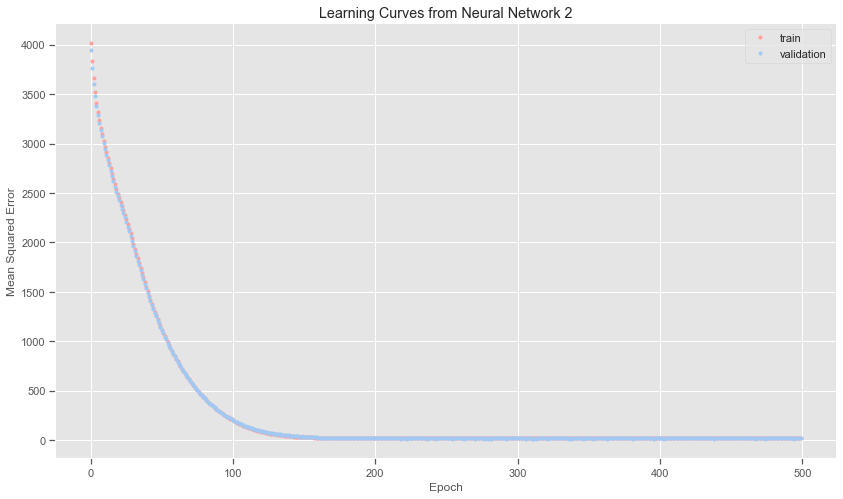

In [90]:
#history = model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=0, validation_split=0.3)
plt.title('Learning Curves from Neural Network 2')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(history2.history['loss'], 'r.',label='train')
plt.plot(history2.history['val_loss'], 'b.',label='validation')
plt.legend()
plt.show()

In [104]:
# Evaluate the model
print("Evaluating neural network model 2")
train_mse2 = model2.evaluate(X_train, y_train, verbose=0)
test_mse2 = model2.evaluate(X_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse2, test_mse2))

train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Training data RMSE: %.3f, Test data RMSE: %.3f' % (train_rmse2, test_rmse2))

Evaluating neural network model 2
Train MSE: 16.859, Test MSE: 19.127
Training data RMSE: 4.106, Test data RMSE: 4.373


#### Predictions with the model

In [91]:
model2_predictions = model2.predict(X_test)

In [93]:
#model2.save('models/model2.h5')

#### Reduce the number of layers
Here I am just seeing how reducing the number of layers and the number of neurons will affect the final results.

#### Define the model

In [96]:
# define a model
model3 = kr.models.Sequential()

model3.add(kr.layers.Dense(30, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))


model3.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

#### Compile the model

In [97]:
# compile the model
model3.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 30)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


#### Fit the model

In [98]:
# fit the model
history3=model3.fit(X_train, y_train, validation_split=0.2,epochs=500, batch_size=10) #verbose=0

Epoch 1/500
29/29 [==============================] - 0s 5ms/step - loss: 4088.3784 - val_loss: 4091.4778
Epoch 2/500
29/29 [==============================] - 0s 2ms/step - loss: 4037.0186 - val_loss: 4037.1724
Epoch 3/500
29/29 [==============================] - 0s 2ms/step - loss: 3978.4824 - val_loss: 3969.1172
Epoch 4/500
29/29 [==============================] - 0s 2ms/step - loss: 3904.9407 - val_loss: 3883.1768
Epoch 5/500
29/29 [==============================] - 0s 2ms/step - loss: 3807.9041 - val_loss: 3770.9956
Epoch 6/500
29/29 [==============================] - 0s 2ms/step - loss: 3683.0725 - val_loss: 3638.4790
Epoch 7/500
29/29 [==============================] - 0s 2ms/step - loss: 3551.9231 - val_loss: 3505.3674
Epoch 8/500
29/29 [==============================] - 0s 2ms/step - loss: 3431.7913 - val_loss: 3392.9346
Epoch 9/500
29/29 [==============================] - 0s 2ms/step - loss: 3336.2075 - val_loss: 3308.7334
Epoch 10/500
29/29 [==============================] - 0

29/29 [==============================] - 0s 2ms/step - loss: 1174.1150 - val_loss: 1167.1888
Epoch 79/500
29/29 [==============================] - 0s 2ms/step - loss: 1155.2689 - val_loss: 1149.5084
Epoch 80/500
29/29 [==============================] - 0s 2ms/step - loss: 1137.3696 - val_loss: 1131.0106
Epoch 81/500
29/29 [==============================] - 0s 2ms/step - loss: 1119.7455 - val_loss: 1113.9537
Epoch 82/500
29/29 [==============================] - 0s 2ms/step - loss: 1101.8469 - val_loss: 1096.1746
Epoch 83/500
29/29 [==============================] - 0s 2ms/step - loss: 1084.4579 - val_loss: 1079.2681
Epoch 84/500
29/29 [==============================] - 0s 2ms/step - loss: 1067.3032 - val_loss: 1062.8514
Epoch 85/500
29/29 [==============================] - 0s 2ms/step - loss: 1050.4138 - val_loss: 1046.0415
Epoch 86/500
29/29 [==============================] - 0s 2ms/step - loss: 1033.7335 - val_loss: 1029.0302
Epoch 87/500
29/29 [==============================] - 0s 2m

29/29 [==============================] - 0s 2ms/step - loss: 300.4130 - val_loss: 300.4664
Epoch 157/500
29/29 [==============================] - 0s 2ms/step - loss: 295.2107 - val_loss: 294.9490
Epoch 158/500
29/29 [==============================] - 0s 2ms/step - loss: 289.4863 - val_loss: 290.0046
Epoch 159/500
29/29 [==============================] - 0s 2ms/step - loss: 284.0145 - val_loss: 283.8620
Epoch 160/500
29/29 [==============================] - 0s 2ms/step - loss: 278.5604 - val_loss: 278.8250
Epoch 161/500
29/29 [==============================] - 0s 2ms/step - loss: 273.4147 - val_loss: 273.4281
Epoch 162/500
29/29 [==============================] - 0s 2ms/step - loss: 268.7419 - val_loss: 267.5982
Epoch 163/500
29/29 [==============================] - 0s 2ms/step - loss: 263.1267 - val_loss: 263.6134
Epoch 164/500
29/29 [==============================] - 0s 2ms/step - loss: 258.2513 - val_loss: 258.0944
Epoch 165/500
29/29 [==============================] - 0s 2ms/step - 

29/29 [==============================] - 0s 2ms/step - loss: 71.6047 - val_loss: 64.8279
Epoch 235/500
29/29 [==============================] - 0s 2ms/step - loss: 70.5900 - val_loss: 64.5383
Epoch 236/500
29/29 [==============================] - 0s 2ms/step - loss: 69.6779 - val_loss: 62.9204
Epoch 237/500
29/29 [==============================] - 0s 2ms/step - loss: 68.6643 - val_loss: 61.9765
Epoch 238/500
29/29 [==============================] - 0s 2ms/step - loss: 67.5169 - val_loss: 61.2645
Epoch 239/500
29/29 [==============================] - 0s 3ms/step - loss: 66.2643 - val_loss: 58.9726
Epoch 240/500
29/29 [==============================] - 0s 3ms/step - loss: 65.0983 - val_loss: 58.8639
Epoch 241/500
29/29 [==============================] - 0s 3ms/step - loss: 64.2714 - val_loss: 57.5873
Epoch 242/500
29/29 [==============================] - 0s 3ms/step - loss: 63.6182 - val_loss: 56.0158
Epoch 243/500
29/29 [==============================] - 0s 2ms/step - loss: 62.3556 - va

29/29 [==============================] - 0s 3ms/step - loss: 32.2889 - val_loss: 24.2516
Epoch 314/500
29/29 [==============================] - 0s 3ms/step - loss: 32.3689 - val_loss: 23.8262
Epoch 315/500
29/29 [==============================] - 0s 2ms/step - loss: 31.9147 - val_loss: 24.0253
Epoch 316/500
29/29 [==============================] - 0s 4ms/step - loss: 31.8378 - val_loss: 23.8876
Epoch 317/500
29/29 [==============================] - 0s 3ms/step - loss: 31.5988 - val_loss: 23.6592
Epoch 318/500
29/29 [==============================] - 0s 3ms/step - loss: 31.6367 - val_loss: 23.2668
Epoch 319/500
29/29 [==============================] - 0s 4ms/step - loss: 31.4897 - val_loss: 23.0459
Epoch 320/500
29/29 [==============================] - 0s 4ms/step - loss: 31.1265 - val_loss: 23.3848
Epoch 321/500
29/29 [==============================] - 0s 3ms/step - loss: 31.3248 - val_loss: 22.8217
Epoch 322/500
29/29 [==============================] - 0s 2ms/step - loss: 31.2254 - va

29/29 [==============================] - 0s 4ms/step - loss: 24.4767 - val_loss: 17.4652
Epoch 393/500
29/29 [==============================] - 0s 2ms/step - loss: 24.3535 - val_loss: 17.7758
Epoch 394/500
29/29 [==============================] - 0s 2ms/step - loss: 24.3709 - val_loss: 18.0356
Epoch 395/500
29/29 [==============================] - 0s 2ms/step - loss: 24.2264 - val_loss: 17.4010
Epoch 396/500
29/29 [==============================] - 0s 2ms/step - loss: 24.0892 - val_loss: 17.6613
Epoch 397/500
29/29 [==============================] - 0s 4ms/step - loss: 24.1591 - val_loss: 17.4142
Epoch 398/500
29/29 [==============================] - 0s 3ms/step - loss: 24.2476 - val_loss: 17.4389
Epoch 399/500
29/29 [==============================] - 0s 3ms/step - loss: 24.3321 - val_loss: 17.7292
Epoch 400/500
29/29 [==============================] - 0s 4ms/step - loss: 23.9251 - val_loss: 17.4092
Epoch 401/500
29/29 [==============================] - 0s 2ms/step - loss: 23.8351 - va

29/29 [==============================] - 0s 2ms/step - loss: 20.9104 - val_loss: 15.4369
Epoch 472/500
29/29 [==============================] - 0s 2ms/step - loss: 20.8446 - val_loss: 15.3032
Epoch 473/500
29/29 [==============================] - 0s 2ms/step - loss: 20.7669 - val_loss: 15.5923
Epoch 474/500
29/29 [==============================] - 0s 2ms/step - loss: 20.7635 - val_loss: 15.3069
Epoch 475/500
29/29 [==============================] - 0s 2ms/step - loss: 20.8662 - val_loss: 15.6471
Epoch 476/500
29/29 [==============================] - 0s 3ms/step - loss: 20.7458 - val_loss: 15.1790
Epoch 477/500
29/29 [==============================] - 0s 2ms/step - loss: 20.9575 - val_loss: 15.6758
Epoch 478/500
29/29 [==============================] - 1s 19ms/step - loss: 20.6749 - val_loss: 15.4448
Epoch 479/500
29/29 [==============================] - 0s 9ms/step - loss: 20.5999 - val_loss: 15.4007
Epoch 480/500
29/29 [==============================] - 0s 6ms/step - loss: 20.5659 - v

#### Evaluate the model

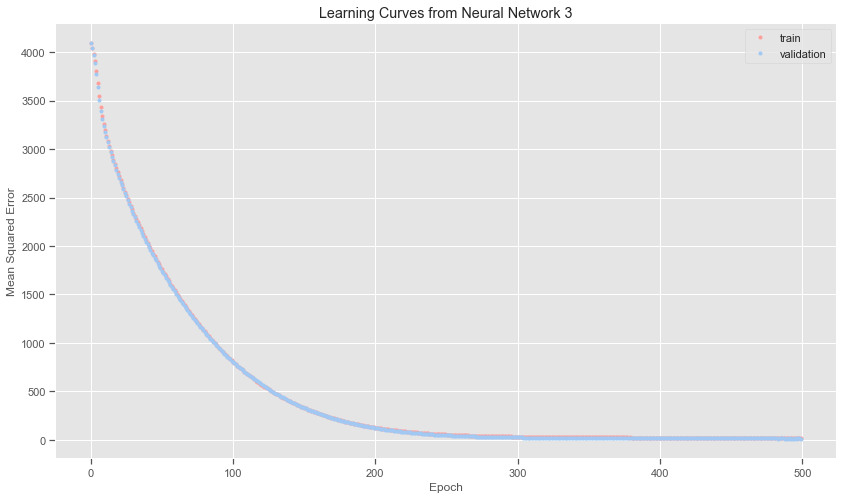

In [102]:
#history = model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=0, validation_split=0.3)
plt.title('Learning Curves from Neural Network 3')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(history3.history['loss'], 'r.',label='train')
plt.plot(history3.history['val_loss'], 'b.',label='validation')
plt.legend()
plt.show()

In [103]:
# Evaluate the model
print("Evaluating Neural Network model 3")
train_mse3 = model3.evaluate(X_train, y_train, verbose=0)
test_mse3 = model3.evaluate(X_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse3, test_mse3))


train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Training data RMSE: %.3f, Test data RMSE: %.3f' % (train_rmse3, test_rmse3))

Train MSE: 18.947, Test MSE: 18.291
Training data RMSE: 4.353, Test data RMSE: 4.277


#### Predictions with the model

In [110]:
model3_predictions = model3.predict(X_test)

#### Comparing the two neural network models:


### Comparing Models
*The goal is to choose a model configuration and training configuration that achieve the lowest loss and highest accuracy possible for a given dataset.* [24]

The plots are a convenient way of visualising how each model performs compared to the actual data. 
There is not much difference between the 3rd and 4th order polynomial regression models apart from the speed values below 5 metres per second.
The learning curves for the neural networks showed that the loss fell quite dramatically for the first 100 or so iterations but then it levels off and does not come down below 16 despite playing around with the parameters.

The ideal loss is is zero and the ideal accuracy is 1.0 or 100%.



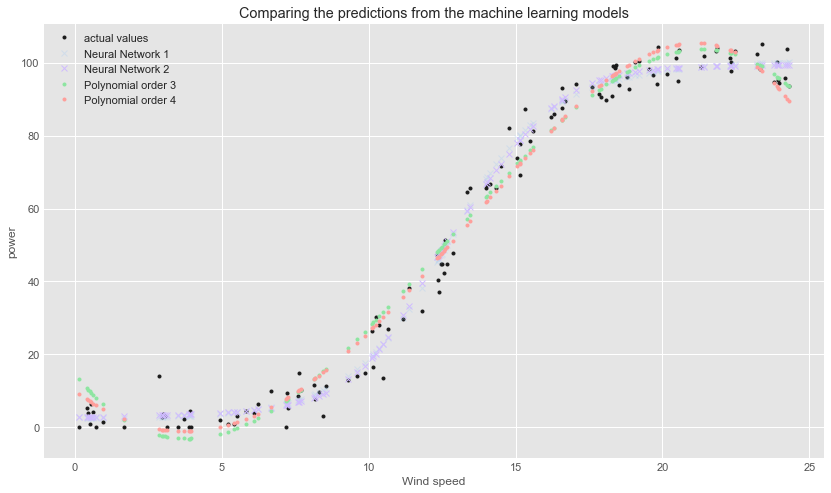

In [143]:
### Plot the predictions from the models
plt.style.use('ggplot')
plt.plot(X_test, y_test, 'k.',label ='actual values')
plt.plot(X_test, model_predictions,'bx', alpha=0.3,label="Neural Network 1")
plt.plot(X_test, model2_predictions,'mx',label="Neural Network 2")
plt.plot(X_test, poly3_predictions, '.g', label="Polynomial order 3")
plt.plot(X_test, poly4_predictions, 'r.', label="Polynomial order 4")
plt.xlabel("Wind speed")
plt.ylabel("power")
plt.title("Comparing the predictions from the machine learning models")
plt.legend()
plt.show()


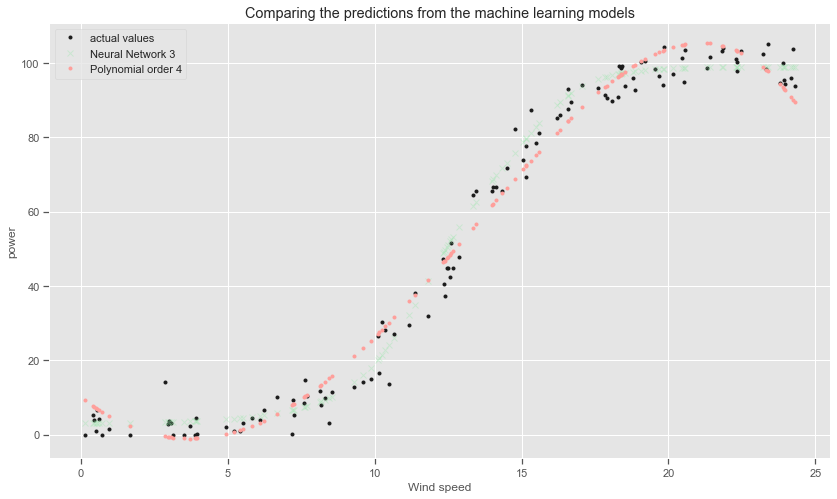

In [113]:
### Plot the predictions from the models

plt.plot(X_test, y_test, 'k.',label ='actual values')

plt.plot(X_test, model_predictions,'gx', alpha=0.3,label="Neural Network 3")
plt.plot(X_test, poly4_predictions, 'r.', label="Polynomial order 4")
plt.xlabel("Wind speed")
plt.ylabel("power")
plt.title("Comparing the predictions from the machine learning models")
plt.legend()
plt.show()

### Look at evaluation metrics for the two models:
Root mean squared error below.
I will leave out one of the neural networks.

#### Polynomial Regression models

In [105]:
print("Evaluating the polynomial regression model with 3 degrees:")
print('Mean squared error: %.2f' % mean_squared_error(y_test,poly3_predictions ))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, poly3_predictions))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test,poly3_predictions )))

Evaluating the polynomial regression model with 3 degrees:
Mean squared error: 33.32
Coefficient of determination: 0.98
Root Mean Squared Error: 5.77


In [106]:
print("Evaluating the polynomial regression model with 4 degrees:")
print('Mean squared error: %.2f' % mean_squared_error(y_test,poly4_predictions ))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, poly4_predictions))
print('Root Mean Squared Error: %.2f' % np.sqrt(mean_squared_error(y_test,poly4_predictions )))

Evaluating the polynomial regression model with 4 degrees:
Mean squared error: 30.80
Coefficient of determination: 0.98
Root Mean Squared Error: 5.55


In [109]:
print("RMSE from Neural Network 1")
print('Training data RMSE: %.3f, Test data RMSE: %.3f' % (train_rmse, test_rmse))
print("\nRMSE from Neural Network 2")
print('Training data RMSE: %.3f, Test data RMSE: %.3f' % (train_rmse2, test_rmse2))
print("\nRMSE from Neural Network 3")
print('Training data RMSE: %.3f, Test data RMSE: %.3f' % (train_rmse3, test_rmse3))

RMSE from Neural Network 1
Training data RMSE: 4.100, Test data RMSE: 4.399

RMSE from Neural Network 2
Training data RMSE: 4.106, Test data RMSE: 4.373

RMSE from Neural Network 3
Training data RMSE: 4.353, Test data RMSE: 4.277


In [ ]:
#import tensorflow.keras as kr
#from tensorflow.keras.models import load_model
#model = load_model('model.h5')
#model2=load_model('model2.h5')

In [ ]:
#import pickle
#import joblib
# In the specific case of scikit-learn, it may be better to use joblib’s replacement of pickle
#from joblib import dump, load

#model_poly3 = joblib.load('model_poly3.joblib')
#mod_poly3 = joblib.load('model_poly3.pkl')

In [ ]:
#mod_poly4 = joblib.load('model_poly4.joblib')


### Summary and Conclusions

Overall this has been an interesting project with which to learn about machine learning algorithms such as artifical neural networks. I think there are limitations though in how accurately we can predict the power values from the wind speed values given the relatively small size of the dataset and the single input feature. In addition there is a lack of detail around the source of the dataset and what exactly the measurements represent.
The first time I looked at the data I wondered if the data values represented measurements over a particular period of time and if the lower values of power might be related to the time taken for the turbines to get up and running before they could generate any power. However looking at the raw data in the csv file, the rows are ordered by ascending values of speed column with the corresponding power values in the other column.


However given this it is still very impressive to see how in a few lines of code a machine learning model can learn to perform such as task by analysing some training examples. All the models developed managed to resemble the general shape of the curve of the data with the artificial neural networks  performing better than the linear regression models.

Creating a better artificial neural network does seem to involve quite a bit of trial and error in terms of selecting the number of neurons, the number of layers, the activation functions and setting the weights and bias parameters. I did research some of these parameters for this project that will be useful as a starting point for any future projects in this area but there is a lot more to learn!

The various machine learning models developed in this project do seem to under predict the power values for the lower values of speed. This is as I expected earlier given that when wind speeds are too low to generate power, the stored power is often used later. The models also extrapolate a value for wind speeds beyond the cut-off rate. 
I excluded some observations from the dataset where the power values were zero for valid reasons such as the turbines being powered off for safety reasons. I assumed that some of the zero values were related to maintenance reasons and excluded these values as outlined. All other observations with zero power values were included as they provide valid information. I think it make sense not to be trying to predict values for a wind turbine that is turned off or not working. Clever and all as the neural networks are they do not know this and therefore it is important for the user to have an understanding of the dataset to avoid making nonsense predictions.

I did experiment with leaving all the observations in, however for each model the power values at the higher wind speed end of the curve were underestimated. 
The neural networks performed better in each case than the polynomial regression models. The 4th degree polynomial did perform better than the 3rd degree polynomial at the lower wind speed end but otherwise the models performed almost the same. The second neural network had an extra layer added in and more neurons in each layer. This did increase the processing time. The improvement in accuracy was small. 
The learning curves for the neural networks showed that the loss fell quite dramatically for the first 100 or so iterations but then it levels off and does not come down below 16 despite playing around with the parameters. Overall the neural network models ended up being the same and cannot be distinguished when plotted together.
Having too many neurons and too many layers might not translate well to a larger dataset. However once a model is perfected it can be saved for later use. I did find that running predictions for individual values in this notebook did generate some tensorflow warning messages. 

The neural networks performed better overall than the linear regression models. 

# References
- [1] Dataset: [power production dataset](https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv) from Ian McLoughlin Github

- [2] Website: [The Irish Wind Energy Association (IWEA)](https://www.iwea.com/about-us/about-us)
- [3] Website: [Smart grid dashboard](http://smartgriddashboard.eirgrid.com/#all/about/wind
- [4] Website: [Wind Energy Basics](https://windeurope.org/about-wind/wind-basics/)
- [5] Website: [how to calculate power output of wind](https://www.windpowerengineering.com/calculate-wind-power-output/)
- [6] Website [calculating energy production from weather forecast in Python](https://medium.com/planet-os/calculating-energy-production-from-weather-forecast-in-python-3c990047daa)
- [7] Research Article: [Wind Turbine Power Curve Modeling Using
Advanced Parametric and Nonparametric Methods](http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf) link provided by [6]
- [8] [Using_machine_learning_to_predict_wind_turbine_power_output](https://www.researchgate.net/publication/257748412_Using_machine_learning_to_predict_wind_turbine_power_output)
- [9] Website: [Wikipedia](https://en.wikipedia.org/wiki/Wind_turbine_design)
- [10] Website: https://www.wind-watch.org/faq-technology.php

- Using machine learning to predict wind turbine power output by A Clifton, L Kilcher, J K Lundquist and P Fleming, ENVIRONMENTAL RESEARCH LETTERS, doi:10.1088/1748-9326/8/2/024009, Environ. Res. Lett. 8 (2013) 024009 (8pp)

- Wind Turbine Power Curve Modeling Using Advanced Parametric and Nonparametric Methods by Shahab Shokrzadeh, Student Member, IEEE, Mohammad Jafari Jozani, and Eric Bibeau. IEEE TRANSACTIONS ON SUSTAINABLE ENERGY, VOL. 5, NO. 4, OCTOBER 2014.  Available from https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6894235

### Machine learning:
- [11]Website: [The Importance of Data Splitting](https://realpython.com/train-test-split-python-data/)
- [12] Website [Polynomial Regressions - extending linear models](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
- [13][Polynomial Regression with Scikit learn: What You Should Know](https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2)
- [14][How to fit a polynomial curve to data using scikit-learn](https://stackoverflow.com/questions/32660231/how-to-fit-a-polynomial-curve-to-data-using-scikit-learn/32660433)
- [15][Python Implementation of Polynomial Regression](https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/)
- [16][sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
- [17][Artificial Neural Networks](https://www.investopedia.com/terms/a/artificial-neural-networks-ann.asp#:~:text=An%20artificial%20neural%20network%20(ANN)%20is%20the%20piece%20of%20a,by%20human%20or%20statistical%20standards.)
- [18][Mit News](https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414)
- [19][Neural Networks Concepts](https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html)
- [20][Tensorflow Tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)


- [21][Tensorflow/tf/keras](https://www.tensorflow.org/api_docs/python/tf/keras)

- [22] [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam]
- Website: [Machine Learning Mastery](https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/)
- [23][Activation functions](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)
- [24][]( https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)

- [Sequential Mode](https://www.tensorflow.org/guide/keras/sequential_mode)
-  [the importance of batch sizes](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

-  [Data Leakage  in Machine Learning](https://machinelearningmastery.com/data-leakage-machine-learning/)
- [Normalisation before or after splitting the data into training and test sets](https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split#:~:text=3%20Answers&text=Normalization%20across%20instances%20should%20be,data%20from%20the%20training%20set.&text=Using%20any%20information%20coming%20from,the%20evaluation%20of%20the%20performance.)
- [Neural Networks](https://www.investopedia.com/terms/n/neuralnetwork.asp#:~:text=A%20neural%20network%20is%20a,organic%20or%20artificial%20in%20nature.)
- [Artificial Neural Network](https://en.wikipedia.org/wiki/Artificial_neural_network)

- https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414

- https://ml-cheatsheet.readthedocs.io/en/latest/index.html

### Other wind turbine research:
- [sem-o.com](https://www.sem-o.com/links/) some more links on 
- [WindEurope](https://windeurope.org/data-and-analysis/)
- http://www.eirgridgroup.com/how-the-grid-works/renewables/
- https://www.wind-watch.org/faq-technology.php
- https://www.sciencedirect.com/topics/engineering/rated-wind-speed 



- Website: [Machine Learning: Polynomial Regression with Python](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)


- Website: [Linear Regression Example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py)

- Website: [Polynomial Regression with Python](https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386)
- Website: [Python | Implementation of Polynomial Regression](https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/)

- Website: [Polynomial Regression in Python](https://medium.com/ai-in-plain-english/implementing-polynomial-regression-in-python-d9aedf520d56)

- Video: [Understanding Polynomial Regression](https://www.youtube.com/watch?v=UedwCvFGlvU) by 
Mazen Ahmed

- Website: [What does RMSE really mean?](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e) Blog article by James Moody

- Website: [Batch Normalization Tensorflow Keras Example](https://towardsdatascience.com/backpropagation-and-batch-normalization-in-feedforward-neural-networks-explained-901fd6e5393e)

- Website: [How to normalize features in TensorFlow](https://towardsdatascience.com/how-to-normalize-features-in-tensorflow-5b7b0e3a4177)
- Website: [Data Leakage in Machine Learning](https://machinelearningmastery.com/data-leakage-machine-learning/)
- Website: [Tutorial on First Neural Network with Python Keras](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)
- Website: [How to use Data Scaling Improve Deep Learning Model Stability and Performance](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)
- Website: [TensorFlow 2 Tutorial: Get Started in Deep Learning With tf.keras](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)

- Website: [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
- Website: [Install TensorFlow with pip](https://www.tensorflow.org/install/pip)

- Website: [Keras Training Guide](https://keras.io/guides/training_with_built_in_methods/)

- Website: [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)

- Website: [pandas.Dataframe.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
 https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/)
 
- Website: [Neural Network](https://www.computing.dcu.ie/~humphrys/Notes/Neural/sigmoid.html)

https://towardsdatascience.com/making-plots-in-jupyter-notebook-beautiful-more-meaningful-23c8a35c0d5d

### End


### Normalisation / Scaling the data or not!
The [Introduction to Keras for Engineers](https://keras.io/getting_started/intro_to_keras_for_engineers/) does suggest that data preprocessing should be done such as feature normalisation.
- Do preprocessing such as feature normalisation.
The data consists of two columns of data and thats it. The only preprocesing that is applicable here is to rescale the data to small values as in general the input values to a neural network should be close to zero. According to the tutorial  the data should either be rescaled to have zero-mean and unit-variance or the data in the `[0.1]` range. The preprocessing should ideally be done as part of the model to make it more portable in production. In Keras the preprocessing is done via preprocessing layers which can be included directly into your model either during training or after training. Some preprocessing layers have a state, in this case normalization holds the mean and variance of the features and can be obtained by calling `layer.adapt(data)` on a sample or all of the training data.

CSV data needs to be parsed, with numerical features converted to floating point tensors and categorical features indexed and converted to integer tensors. Then each feature typically needs to be normalized to zero-mean and unit-variance.

Many examples in blogs only scale the inputs or the target variable but in this dataset we only have a single input variable and a single target variable. Without scaling the model does quite a good job considering all it has are two single columns of numbers. The wind speed seems to be uniformly distributed. I might just note it here but in the final model go without scaling.
The model can be updated to scale the target variable. 
>Reducing the scale of the target variable will, in turn, reduce the size of the gradient used to update the weights and result in a more stable model and training process. [Data Scaling to improve the network](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)[123345]

According to this article, a good rule of thumb is that input variables should be small values, probably in the range of 0-1 or standardized with a zero mean and a standard deviation of one.
>If the distribution of the quantity is normal, then it should be standardized, otherwise the data should be normalized.
If in doubt, normalise the input sequence.

>The output variable is the variable predicted by the network. If the distribution of the value is normal, then you can standardize the output variable. Otherwise, the output variable can be normalized.

Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1. 
Scikit-learn's preprocessing module can be used to scale the data.
>Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.
https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

The data can be scaled to lie between a given minimum and maximum value such as between zero and one or so that the maximum absolute value of each feature is scaled to unit size. 

Normalization should be done after splitting the data into train and test/validation to avoid data leakage. Data leakage is where information from outside the dataset is used to train the model.
Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

As yet I am not fully sure whether I should scale outputs as well as inputs but I think I should as we only have a single input feature to train the model on and predict the outputs.

Continuing with following this blog:
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

>It is best practice is to estimate the mean and standard deviation of the training dataset and use these variables to scale the train and test dataset. This is to avoid any data leakage during the model evaluation process.
>The scikit-learn transformers expect input data to be matrices of rows and columns, therefore the 1D arrays for the target variable will have to be reshaped into 2D arrays prior to the transforms.

